In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

from scipy.ndimage import gaussian_filter

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller,kpss







plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Data Cleaning

In [3]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_store = pd.read_csv('data/store.csv')

In [4]:
df_train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [5]:
# Merge df_store and df_train
df = df_train.merge(df_store, how='left', left_on=df_train.Store, right_on=df_store.Store)
df.drop(['key_0', 'Store_y'], axis=1, inplace=True)
df = df.rename(columns={'Store_x':'Store'})
df.shape

(1017209, 18)

In [6]:
df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN

In [7]:
cols = df.columns.tolist()
cols = [col.lower() for col in cols]
df.columns = cols

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   store                      1017209 non-null  int64  
 1   dayofweek                  1017209 non-null  int64  
 2   date                       1017209 non-null  object 
 3   sales                      1017209 non-null  int64  
 4   customers                  1017209 non-null  int64  
 5   open                       1017209 non-null  int64  
 6   promo                      1017209 non-null  int64  
 7   stateholiday               1017209 non-null  object 
 8   schoolholiday              1017209 non-null  int64  
 9   storetype                  1017209 non-null  object 
 10  assortment                 1017209 non-null  object 
 11  competitiondistance        1014567 non-null  float64
 12  competitionopensincemonth  693861 non-null   float64
 13  competitiono

In [9]:
df = df.assign(
    timestamp = lambda x: pd.to_datetime(x['date']),
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear
)

In [10]:
df.head()

store  dayofweek        date  sales  customers  open  promo stateholiday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   schoolholiday storetype  ... competitionopensinceyear  promo2  \
0              1         c  ...                   2008.0       0   
1              1         a  ...                   2007.0       1   
2              1         a  ...                   2006.0       1   
3              1         c  ...                   2009.0       0   
4              1         a  ...                   2015.0       0   

   promo2sinceweek  promo2sinceyear    promointerval  timestamp  year month  \
0              NaN              NaN              NaN 2015-07-31  2015     7   
1             13.0           2010.0  Jan,Apr,Jul,Oct 2015-07-31  2015     7   
2             14.0           2011.0  Jan,Apr,Jul,Oct 2015-07-31  2015     7   
3              NaN              NaN              NaN 2015-07-31  2015     7   
4              NaN              NaN              NaN 2015-07-31  2015     7   

  day  dayofyear  
0  31        212  
1  31        212  
2  31        212  
3  31        212  
4  31        212  

[5 rows x 23 columns]

In [11]:
df['stateholiday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [12]:
df.stateholiday.value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: stateholiday, dtype: int64

In [13]:
df['stateholiday'].replace({0:'0'}, inplace=True)

In [14]:
df.stateholiday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: stateholiday, dtype: int64

In [15]:
round(df.describe().T,2)

count     mean      std     min     25%  \
store                      1017209.0   558.43   321.91     1.0   280.0   
dayofweek                  1017209.0     4.00     2.00     1.0     2.0   
sales                      1017209.0  5773.82  3849.93     0.0  3727.0   
customers                  1017209.0   633.15   464.41     0.0   405.0   
open                       1017209.0     0.83     0.38     0.0     1.0   
promo                      1017209.0     0.38     0.49     0.0     0.0   
schoolholiday              1017209.0     0.18     0.38     0.0     0.0   
competitiondistance        1014567.0  5430.09  7715.32    20.0   710.0   
competitionopensincemonth   693861.0     7.22     3.21     1.0     4.0   
competitionopensinceyear    693861.0  2008.69     5.99  1900.0  2006.0   
promo2                     1017209.0     0.50     0.50     0.0     0.0   
promo2sinceweek             509178.0    23.27    14.10     1.0    13.0   
promo2sinceyear             509178.0  2011.75     1.66  2009.0  2011.0   
year                       1017209.0  2013.83     0.78  2013.0  2013.0   
month                      1017209.0     5.85     3.33     1.0     3.0   
day                        1017209.0    15.70     8.79     1.0     8.0   
dayofyear                  1017209.0   162.28   101.62     1.0    77.0   

                              50%     75%      max  
store                       558.0   838.0   1115.0  
dayofweek                     4.0     6.0      7.0  
sales                      5744.0  7856.0  41551.0  
customers                   609.0   837.0   7388.0  
open                          1.0     1.0      1.0  
promo                         0.0     1.0      1.0  
schoolholiday                 0.0     0.0      1.0  
competitiondistance        2330.0  6890.0  75860.0  
competitionopensincemonth     8.0    10.0     12.0  
competitionopensinceyear   2010.0  2013.0   2015.0  
promo2                        1.0     1.0      1.0  
promo2sinceweek              22.0    37.0     50.0  
promo2sinceyear            2012.0  2013.0   2015.0  
year                       2014.0  2014.0   2015.0  
month                         6.0     8.0     12.0  
day                          16.0    23.0     31.0  
dayofyear                   153.0   241.0    365.0

### Handling NaN's

In [16]:
df.isnull().sum()

store                             0
dayofweek                         0
date                              0
sales                             0
customers                         0
open                              0
promo                             0
stateholiday                      0
schoolholiday                     0
storetype                         0
assortment                        0
competitiondistance            2642
competitionopensincemonth    323348
competitionopensinceyear     323348
promo2                            0
promo2sinceweek              508031
promo2sinceyear              508031
promointerval                508031
timestamp                         0
year                              0
month                             0
day                               0
dayofyear                         0
dtype: int64

In [17]:
df_store[pd.isnull(df_store.CompetitionDistance)]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

In [18]:
# fill NaN with a median value
df['competitiondistance'].fillna(df['competitiondistance'].median(), inplace = True)
df['competitiondistance'].isnull().sum()

0

In [19]:
tmp = df_store[pd.isnull(df_store.CompetitionOpenSinceYear  )]
tmp[tmp.CompetitionDistance != 0].shape

(354, 10)

In [20]:
tmp = df[pd.isnull(df.promo2sinceweek)]
tmp[tmp.promo2 != 0].shape

(0, 23)

In [21]:
# replace NA's by 0
df.fillna(0, inplace = True)

In [22]:
df.isnull().sum()

store                        0
dayofweek                    0
date                         0
sales                        0
customers                    0
open                         0
promo                        0
stateholiday                 0
schoolholiday                0
storetype                    0
assortment                   0
competitiondistance          0
competitionopensincemonth    0
competitionopensinceyear     0
promo2                       0
promo2sinceweek              0
promo2sinceyear              0
promointerval                0
timestamp                    0
year                         0
month                        0
day                          0
dayofyear                    0
dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   store                      1017209 non-null  int64         
 1   dayofweek                  1017209 non-null  int64         
 2   date                       1017209 non-null  object        
 3   sales                      1017209 non-null  int64         
 4   customers                  1017209 non-null  int64         
 5   open                       1017209 non-null  int64         
 6   promo                      1017209 non-null  int64         
 7   stateholiday               1017209 non-null  object        
 8   schoolholiday              1017209 non-null  int64         
 9   storetype                  1017209 non-null  object        
 10  assortment                 1017209 non-null  object        
 11  competitiondistance        1017209 no

In [24]:
df_test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [25]:
df_test[df_test["Open"].isnull()]

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
479      480    622          4  2015-09-17   NaN      1            0   
1335    1336    622          3  2015-09-16   NaN      1            0   
2191    2192    622          2  2015-09-15   NaN      1            0   
3047    3048    622          1  2015-09-14   NaN      1            0   
4759    4760    622          6  2015-09-12   NaN      0            0   
5615    5616    622          5  2015-09-11   NaN      0            0   
6471    6472    622          4  2015-09-10   NaN      0            0   
7327    7328    622          3  2015-09-09   NaN      0            0   
8183    8184    622          2  2015-09-08   NaN      0            0   
9039    9040    622          1  2015-09-07   NaN      0            0   
10751  10752    622          6  2015-09-05   NaN      0            0   

       SchoolHoliday  
479                0  
1335               0  
2191               0  
3047               0  
4759               0  
5615               0  
6471               0  
7327               0  
8183               0  
9039               0  
10751              0

In [26]:
df_test.fillna(1, inplace=True)

In [27]:
df_test.isnull().sum()

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

### Handling Datatyp

In [28]:
df_test["Open"]= df_test["Open"].astype(int)

In [29]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             41088 non-null  int64 
 1   Store          41088 non-null  int64 
 2   DayOfWeek      41088 non-null  int64 
 3   Date           41088 non-null  object
 4   Open           41088 non-null  int64 
 5   Promo          41088 non-null  int64 
 6   StateHoliday   41088 non-null  object
 7   SchoolHoliday  41088 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 2.5+ MB


### Handling Categorical Data

In [30]:
le = LabelEncoder()

In [31]:
ass_typ = pd.get_dummies(df["assortment"], drop_first=True)
df = pd.concat([df,ass_typ], axis=1)


In [32]:
df["storetype_cat"] = le.fit_transform(df["storetype"])

In [33]:
df["stateholiday_cat"] = le.fit_transform(df["stateholiday"])

In [34]:
df =df.rename(columns={"b" : "ass_extra"})

In [35]:
df =df.rename(columns={"c" : "ass_extended"})

In [36]:
df["stateholiday_cat"].unique()

array([0, 1, 2, 3])

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 27 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   store                      1017209 non-null  int64         
 1   dayofweek                  1017209 non-null  int64         
 2   date                       1017209 non-null  object        
 3   sales                      1017209 non-null  int64         
 4   customers                  1017209 non-null  int64         
 5   open                       1017209 non-null  int64         
 6   promo                      1017209 non-null  int64         
 7   stateholiday               1017209 non-null  object        
 8   schoolholiday              1017209 non-null  int64         
 9   storetype                  1017209 non-null  object        
 10  assortment                 1017209 non-null  object        
 11  competitiondistance        1017209 no

In [38]:
df.stateholiday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: stateholiday, dtype: int64

In [39]:
df.stateholiday_cat.value_counts()

0    986159
1     20260
2      6690
3      4100
Name: stateholiday_cat, dtype: int64

# Eda

## Question: Are the Promos effective?

In [40]:
df.groupby('storetype')['sales'].describe()

count          mean          std  min     25%     50%       75%  \
storetype                                                                       
a          551627.0   5738.179710  3964.028134  0.0  3508.0  5618.0   7860.00   
b           15830.0  10058.837334  5280.525506  0.0  6227.0  9025.5  13082.75   
c          136840.0   5723.629246  3721.700886  0.0  3789.0  5766.0   7849.00   
d          312912.0   5641.819243  3473.393781  0.0  3986.0  5826.0   7691.00   

               max  
storetype           
a          41551.0  
b          38722.0  
c          31448.0  
d          38037.0

In [41]:
df.groupby('storetype')['customers', 'sales'].sum()

customers       sales
storetype                       
a          363541434  3165334859
b           31465621   159231395
c           92129705   783221426
d          156904995  1765392943

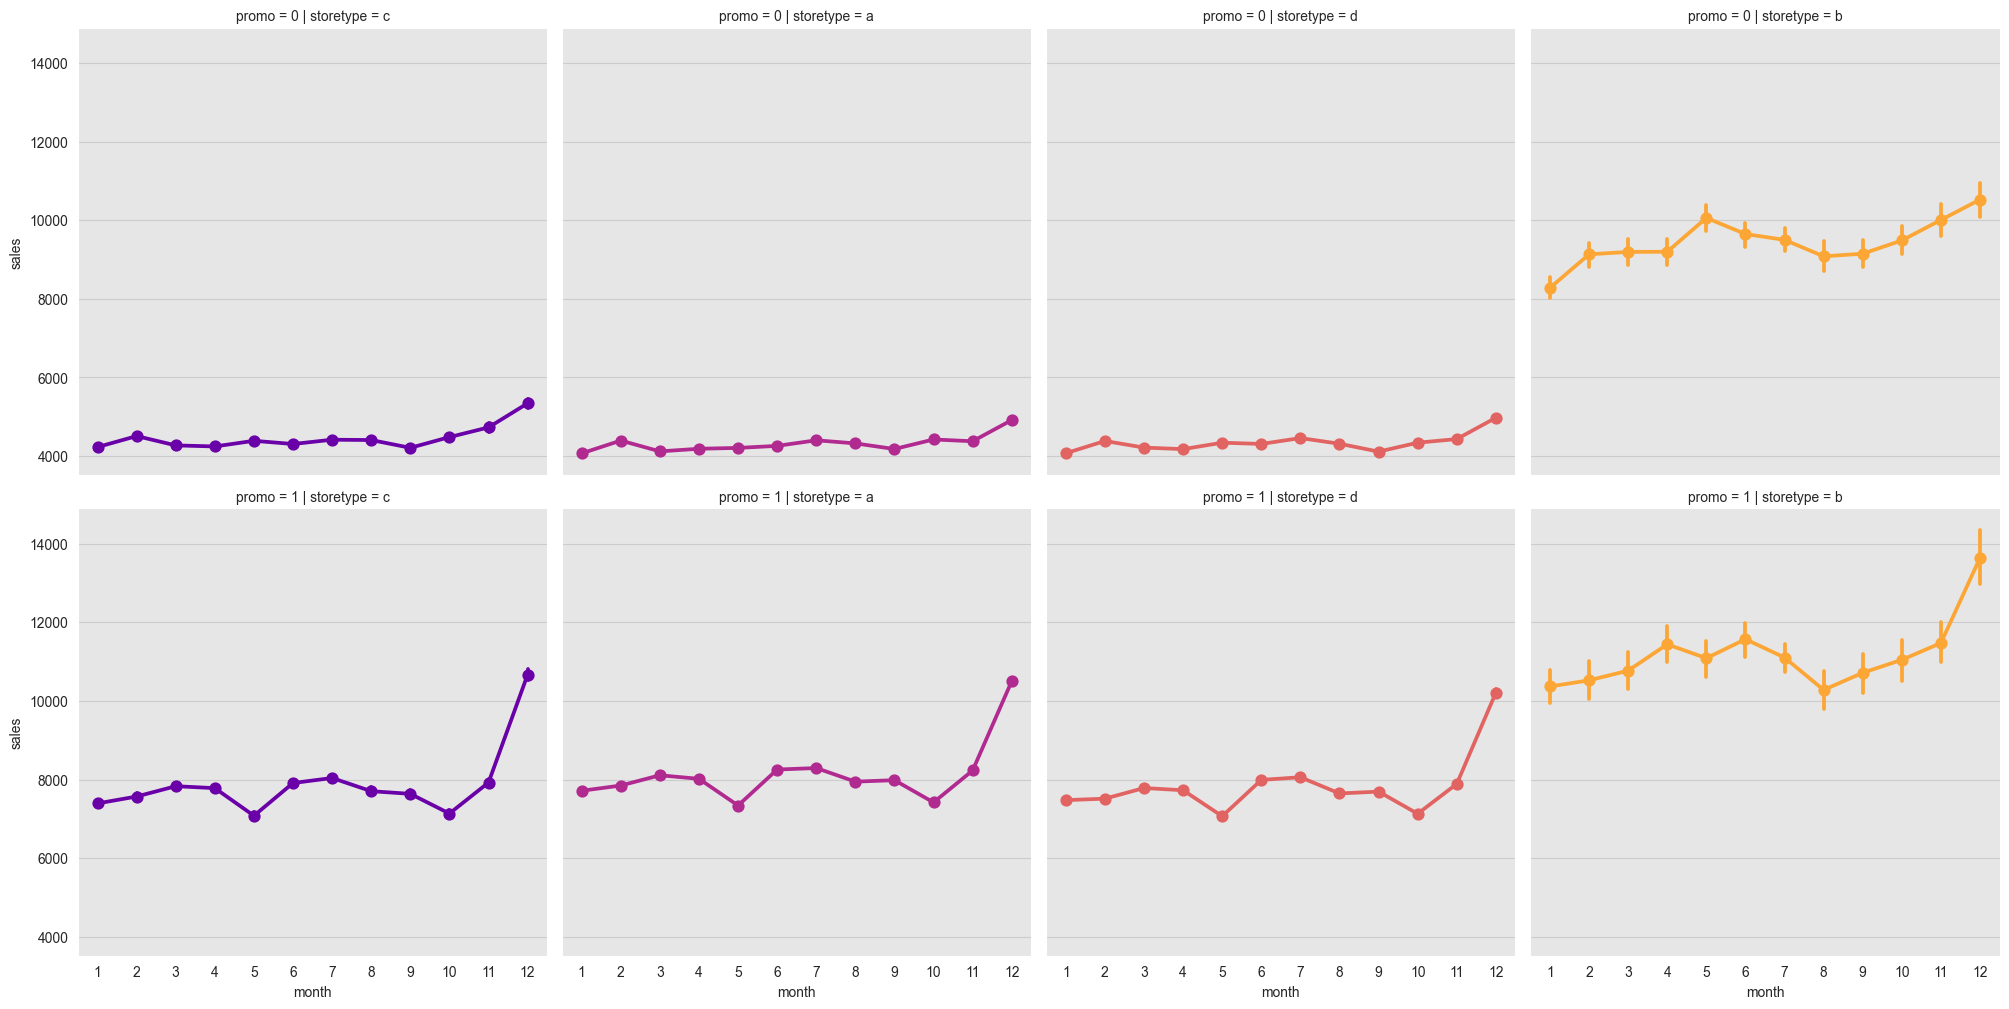

In [42]:
# sales trends
sns.factorplot(data = df, x = 'month', y = "sales", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo', 
               ) 

## Finding

Storetype B has the highest sales numbers, with the largest variance. All storetypes show increased sales numbers towards christmas. 

Stores which have run a promo, show higher sales. But storetypes a,c and d show a dip towards easter, if they have run a promo, which is not the case for stores without a promo.

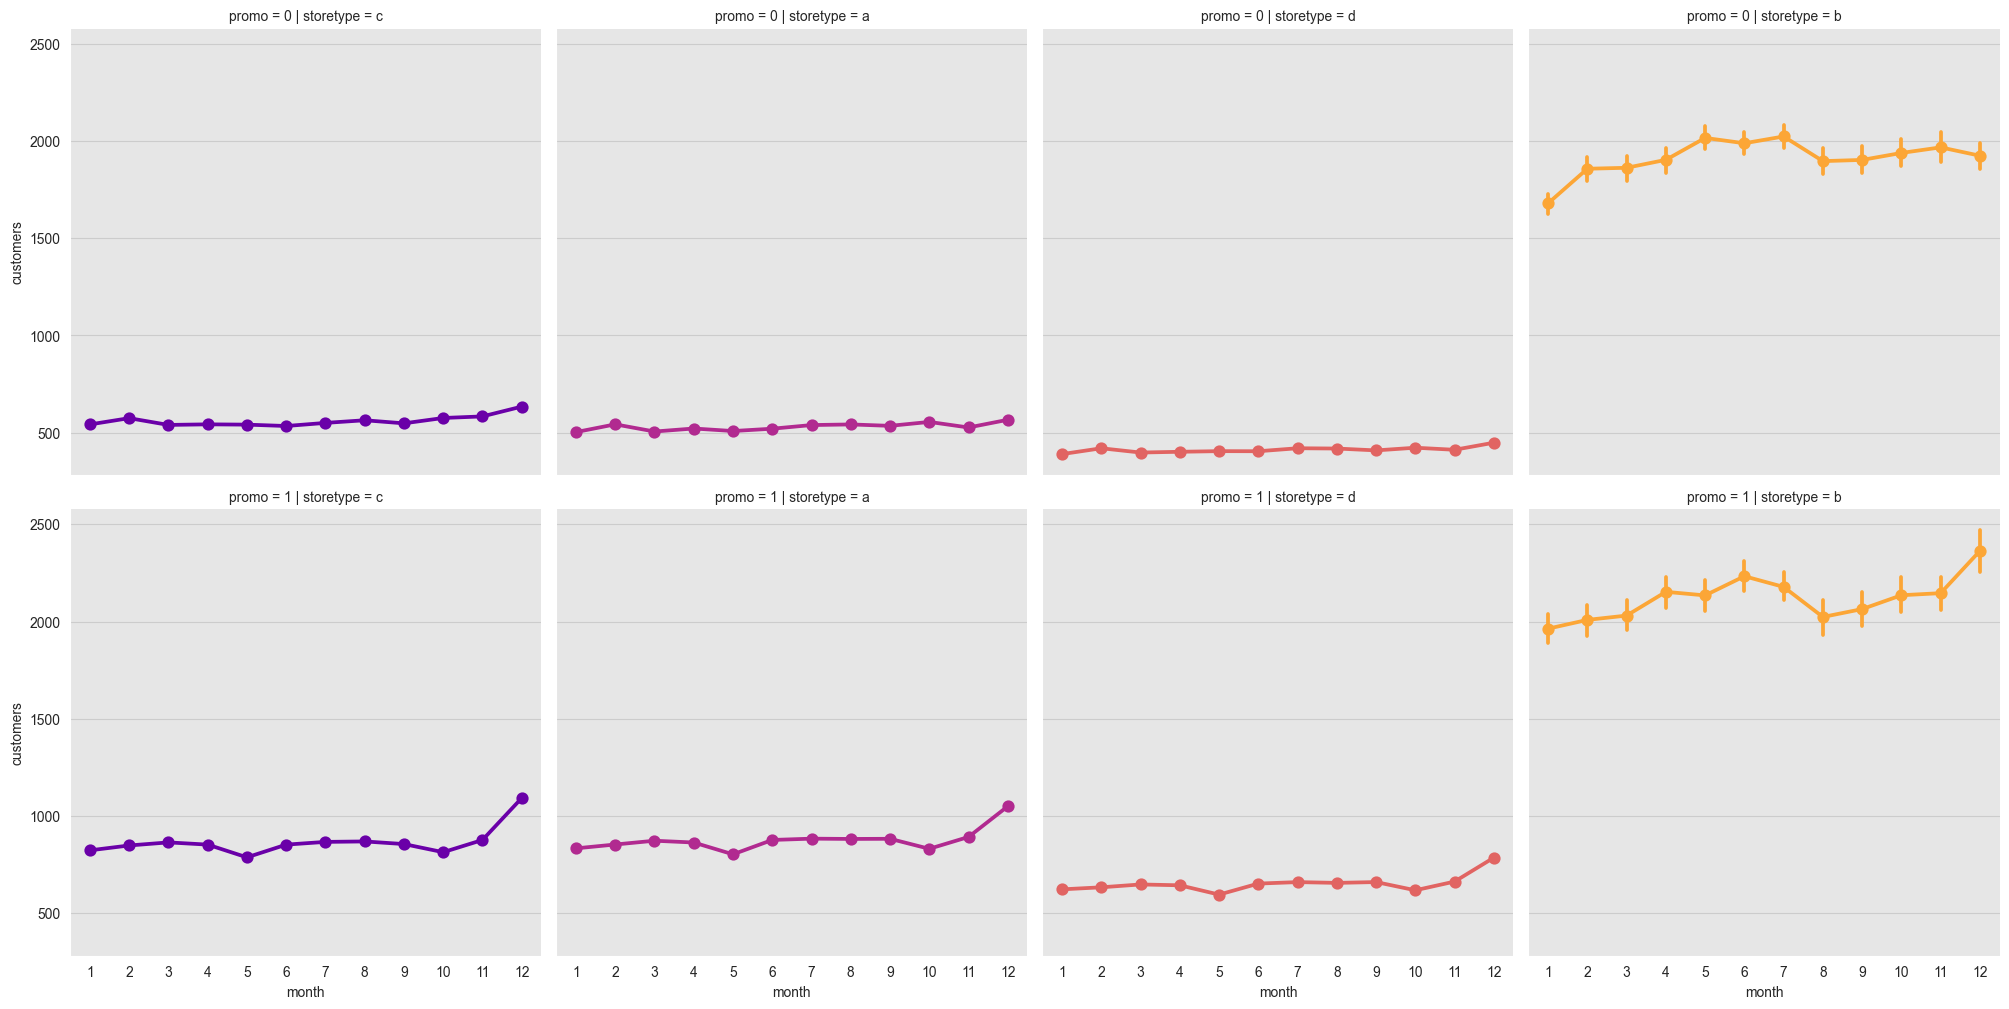

In [43]:
# customers trends
sns.factorplot(data = df, x = 'month', y = "customers", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

## Finding

Storetype B has the highest number of customers, with the largest variance. All storetypes show an increase of customers towards christmas. This trend is higher, if they have run a promo.

Same effect of a dip for storetypes a,c and d in customers towards easter can be also be seen here.

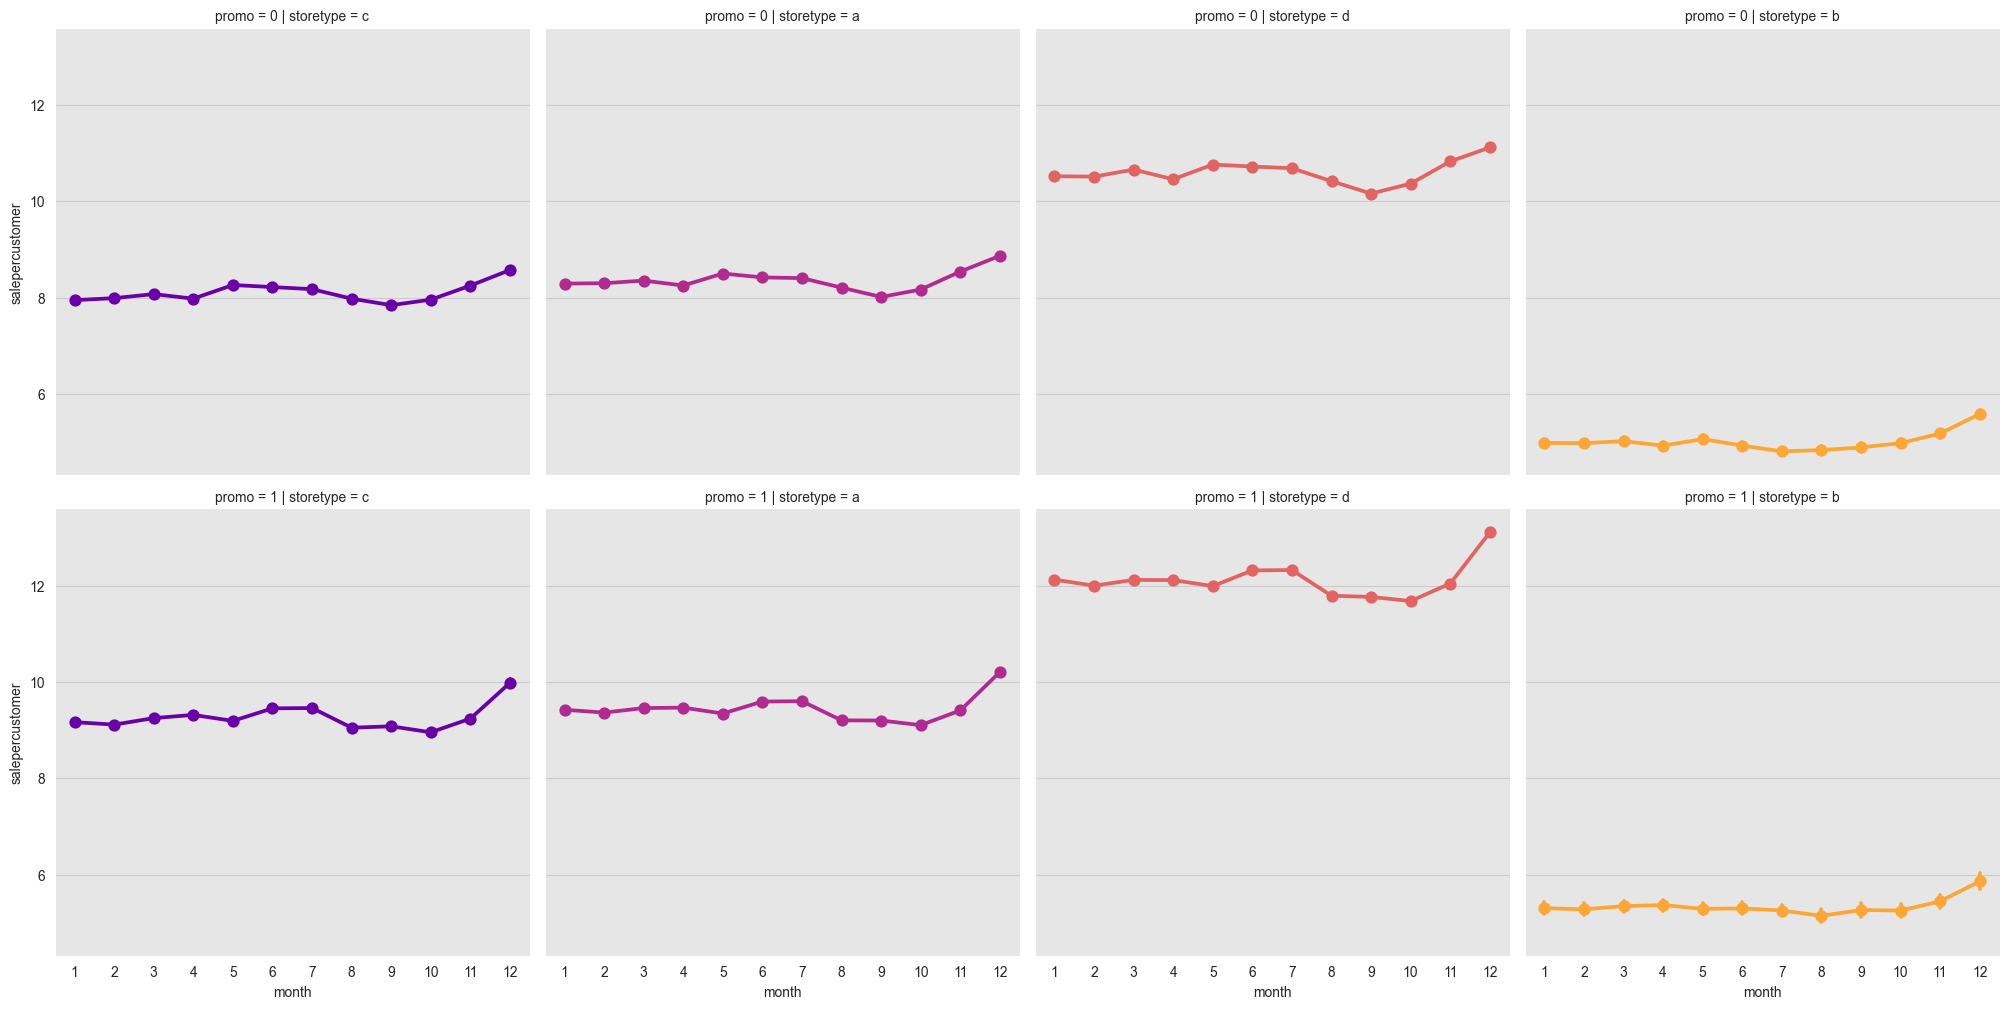

In [44]:
# sale per customer trends
df['salepercustomer'] = df['sales']/df['customers']
sns.factorplot(data = df, x = 'month', y = "salepercustomer", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo', 
               ) 

## Finding

Sales per customer:
storetype b seems to be where customers only buy small items in low numbers (possible trainstation location?)
storetype d customers buy the largest quantity
a und c are very similar

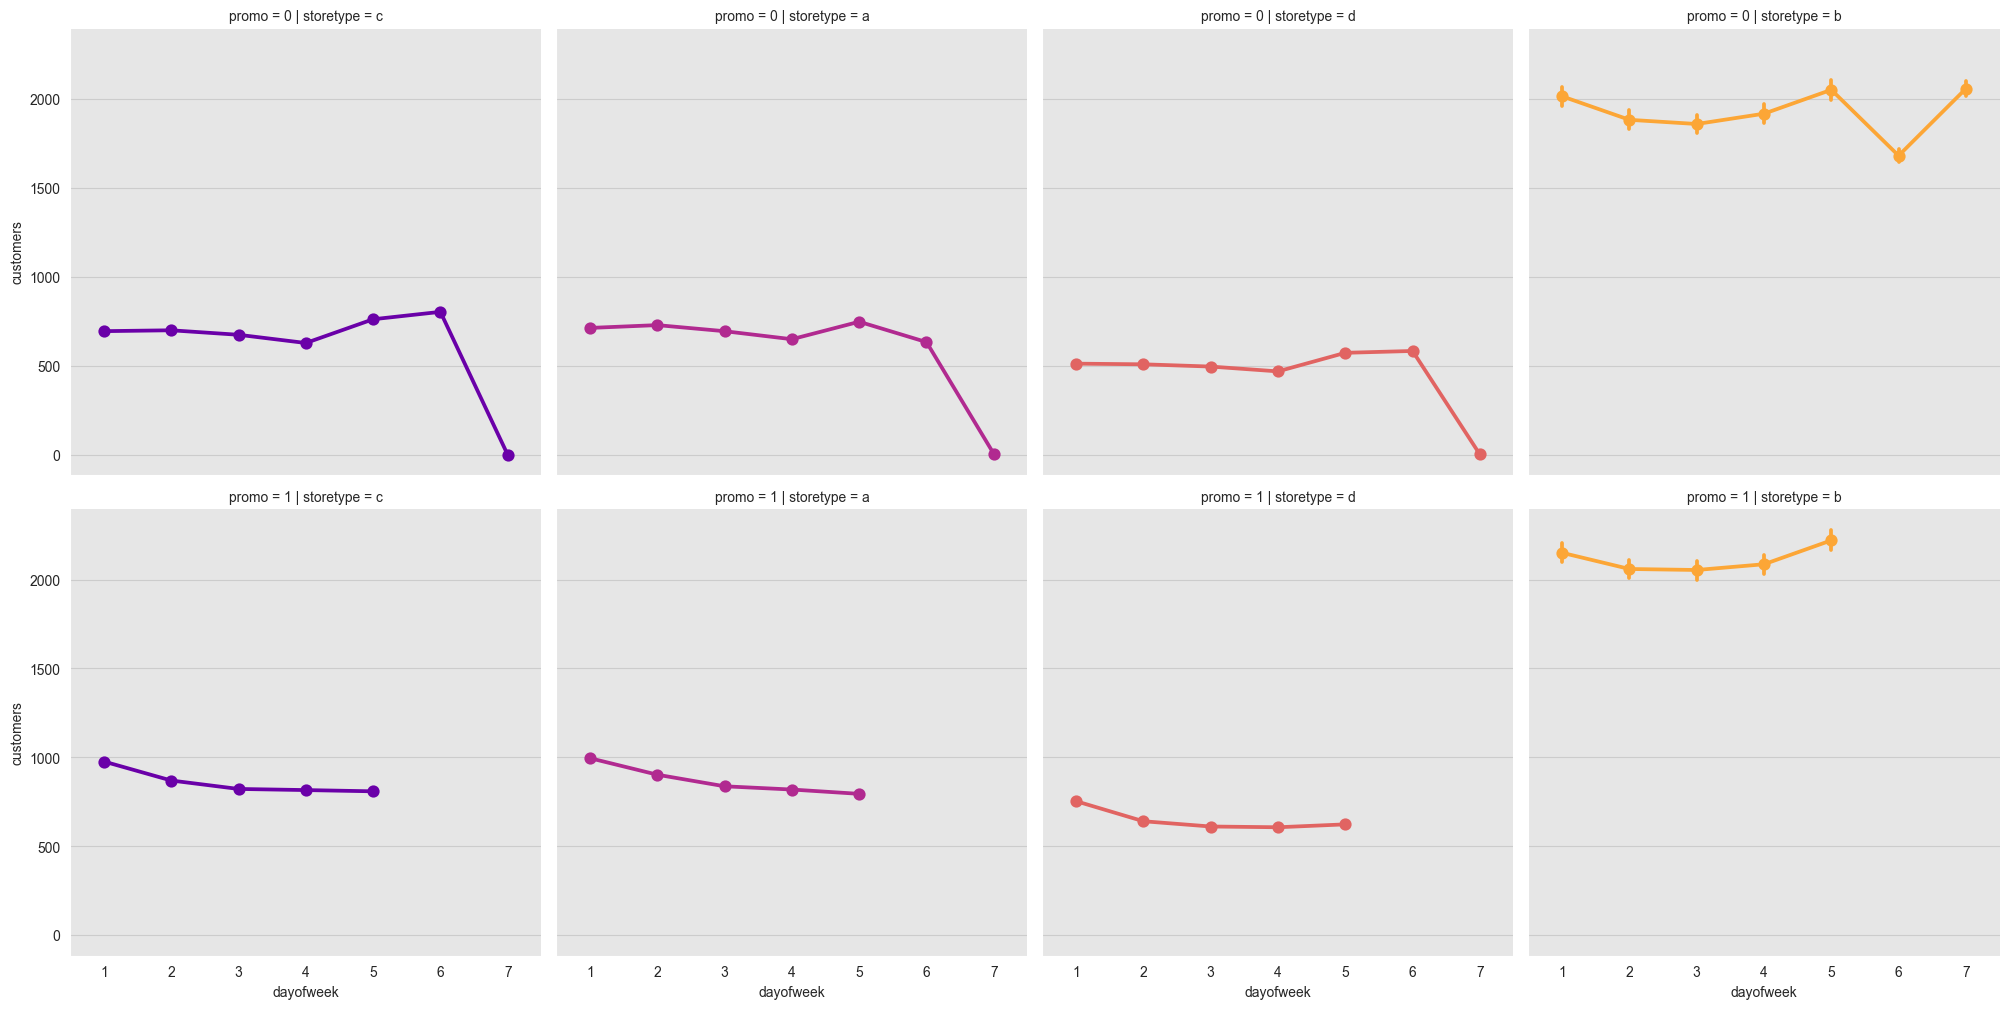

In [45]:
# weekday trends
sns.factorplot(data = df, x = 'dayofweek', y = "customers", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

## Finding

Promos are run only during the work-week, no promo on saturday/sunday.

Storetype b also open on sundays -> trainstation, fo sho
storetyp a lower number of customers on saturday, c and d increased

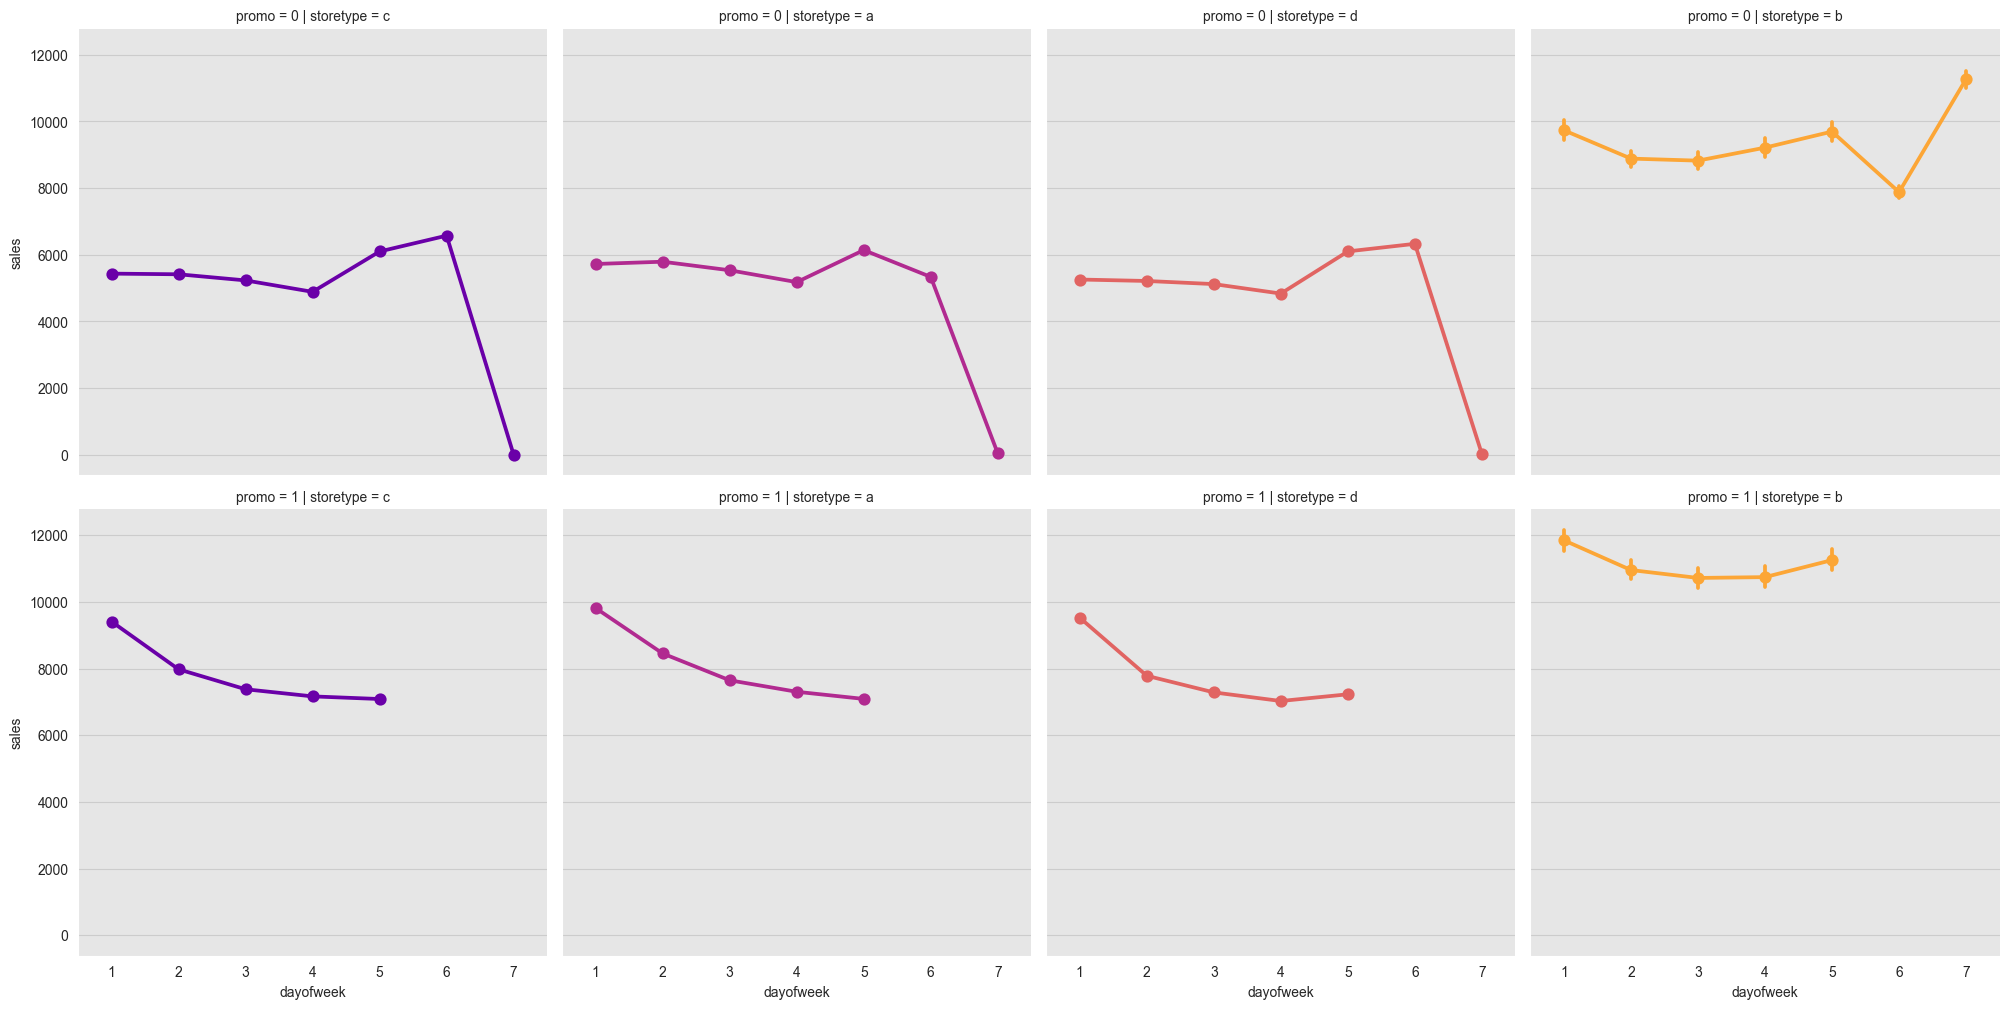

In [46]:
# weekday trends
sns.factorplot(data = df, x = 'dayofweek', y = "sales", 
               col = 'storetype',
               palette = 'plasma',
               hue = 'storetype',
               row = 'promo',
               ) 

Similar trends regarding sales numbers and customers.
Highest number of sales and customers on mondays, if a promo was run

## Conclusion : Question: Are the Promos effective?"
- Promos are run only during the work-week, no promo on saturday/sunday\n",
- Storetype B has the highest number of customers, with the largest variance\n",
- Storetype B has the highest sales numbers, with the largest variance\n",
- All storetypes show increased sales numbers towards christmas\n",
- Stores which have run a promo, show higher sales. But storetypes a, c and d show a dip towards easter, if they have run a promo, which is not the case for stores without a promo."

In [47]:
## beachte: date, (assortment, storetype und stateholiday,assortment) müssen noch raus. die in der klammer sind schon durch kategorische Variablen ersetzt

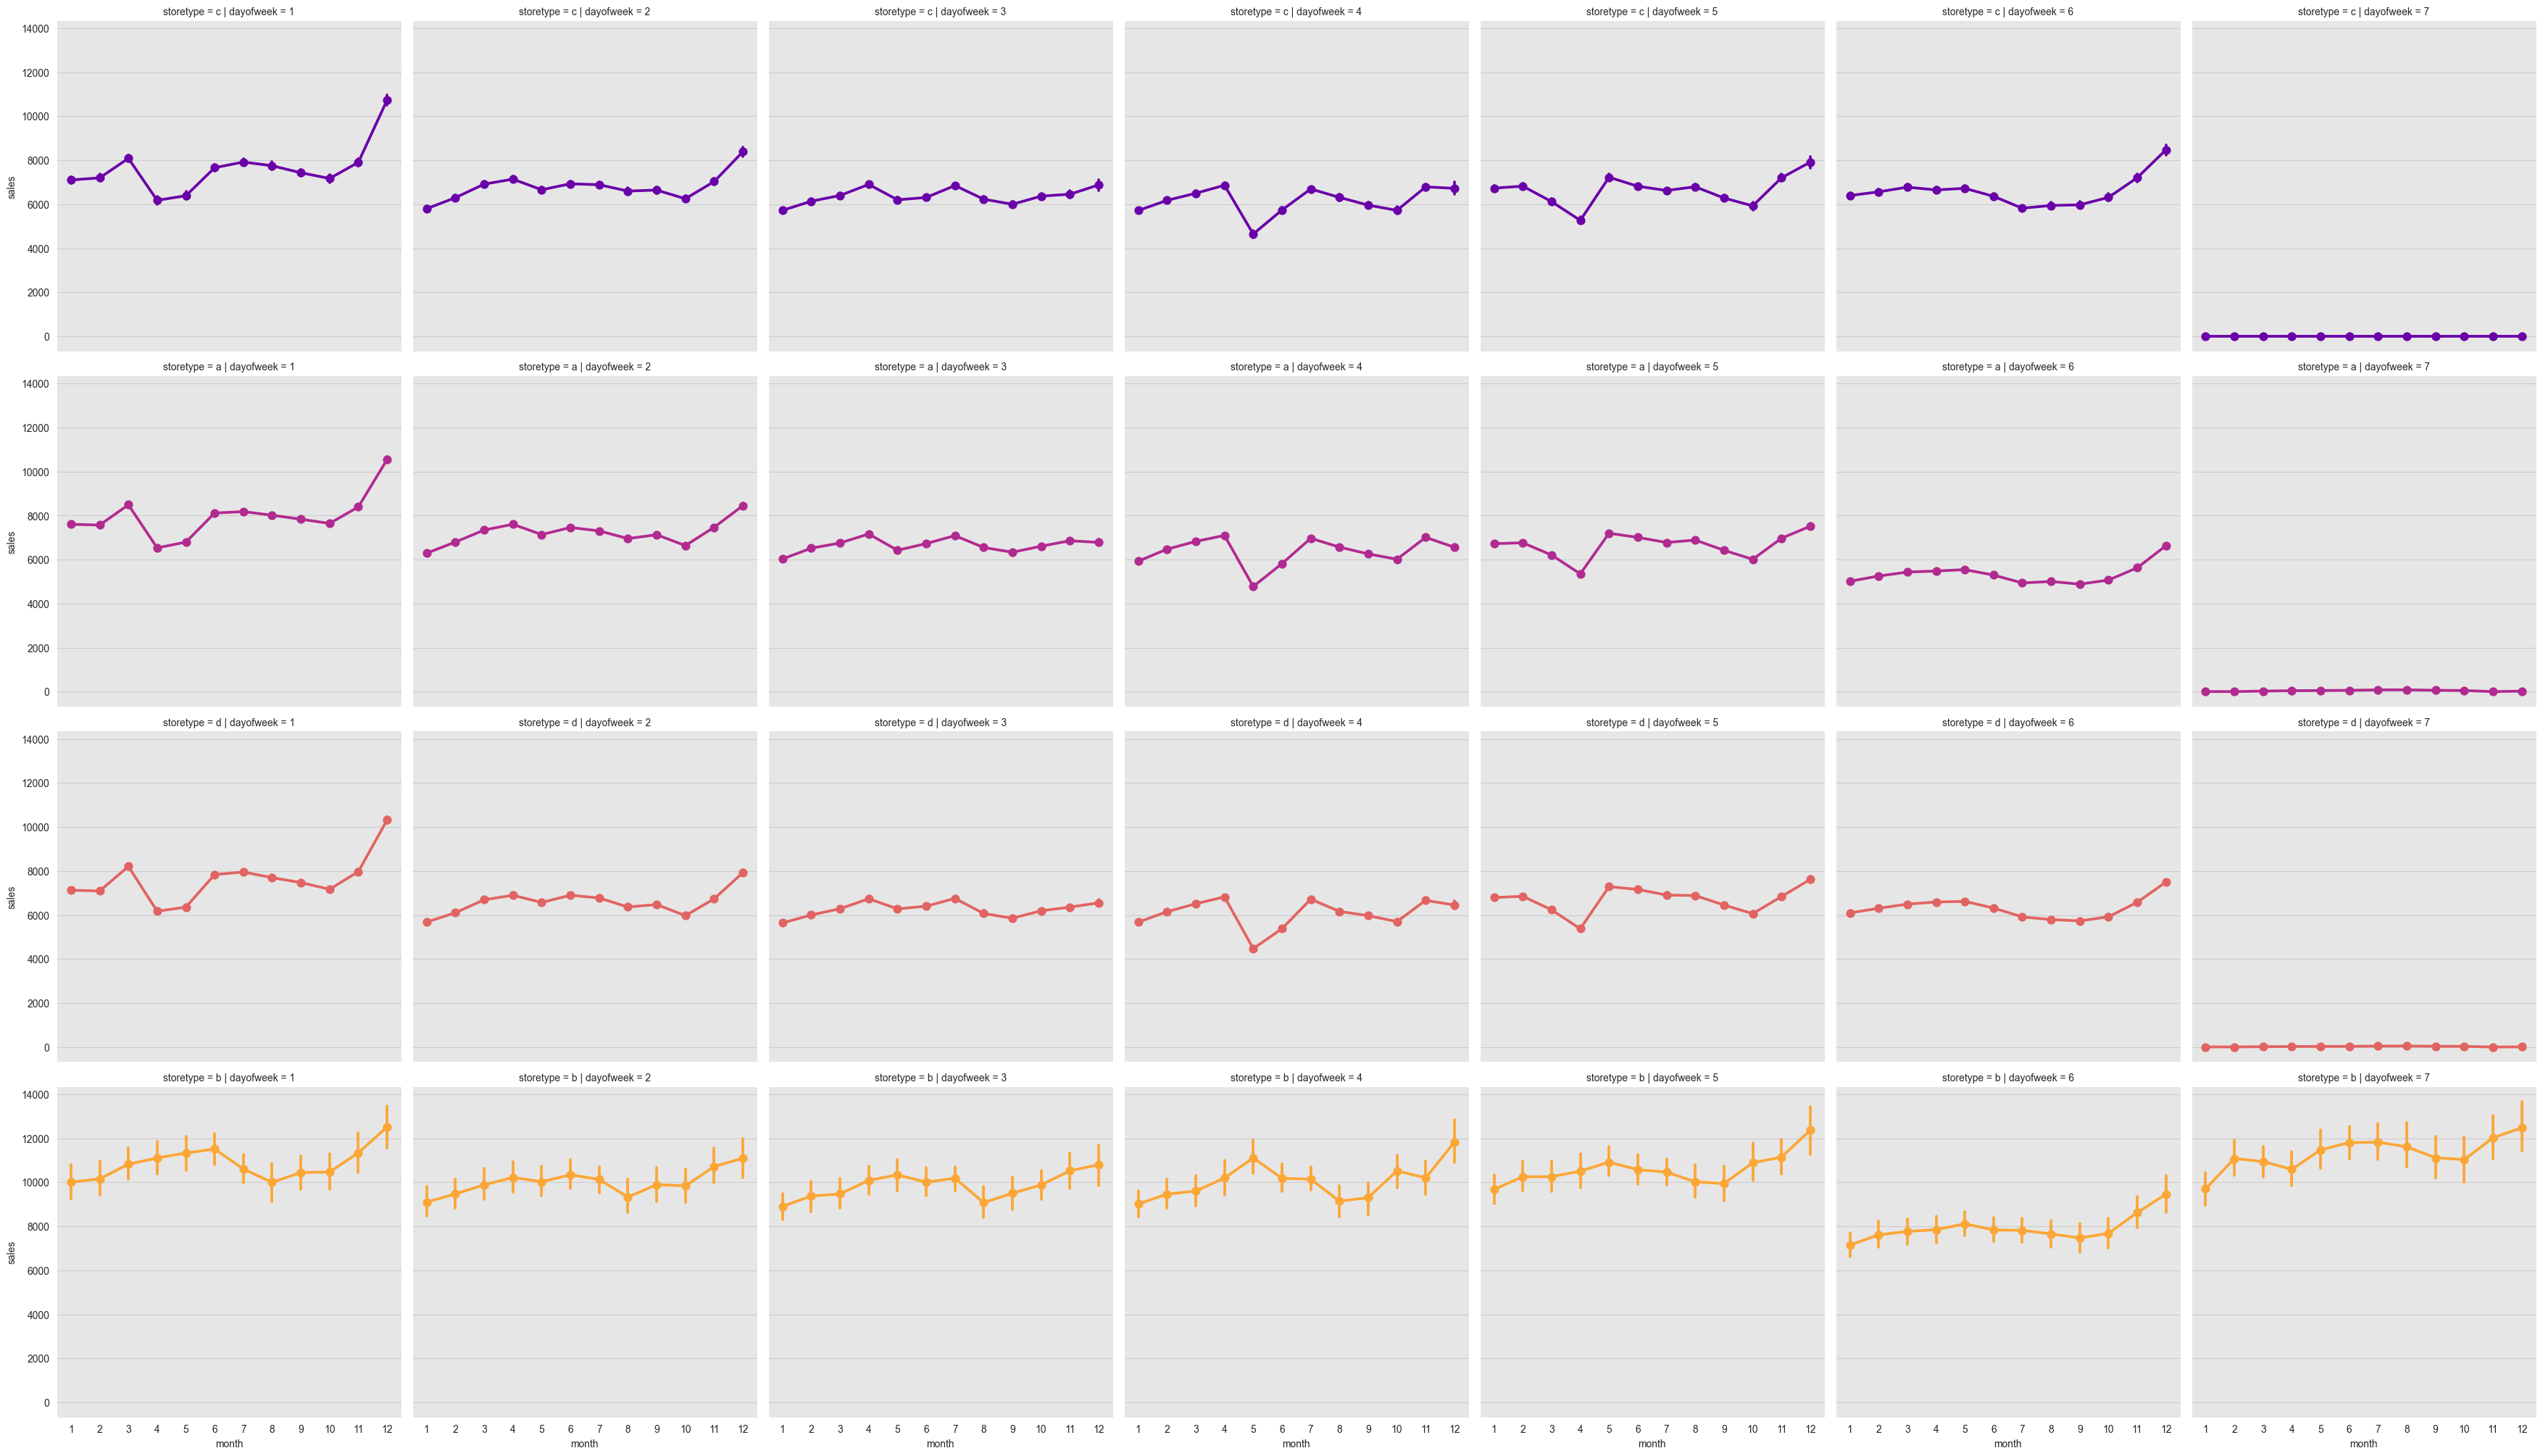

In [48]:
sns.factorplot(data = df, x = 'month', y = "sales", 
               col = 'dayofweek', 
               palette = 'plasma',
               hue = 'storetype',
               row = 'storetype',
               ) 

This shows the sales per storetyp across all months for each weekday.

In [49]:
# stores which are opened on Sundays
df[(df.open == 1) & (df.dayofweek == 7)]['store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  931,  948, 1045, 1081, 1097, 1099,  877])

These are the stores, which are open on sundays.

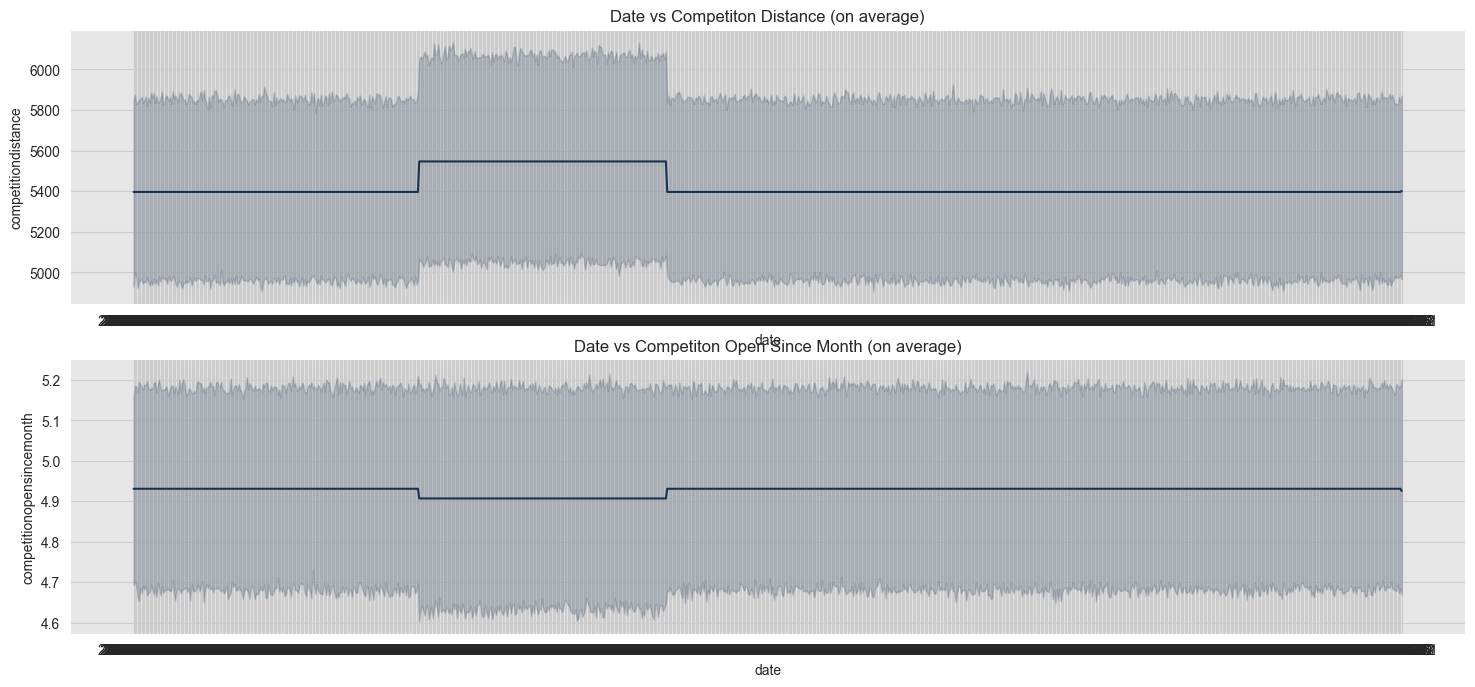

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
sns.lineplot(x = "date", y = df.groupby(df.index).mean()["competitiondistance"] , data=df, ax=axes[0])
sns.lineplot(x = "date", y = df.groupby(df.index).mean()["competitionopensincemonth"]  , data=df, ax=axes[1])

axes[0].set_title("Date vs Competiton Distance (on average)")
axes[1].set_title("Date vs Competiton Open Since Month (on average)")
plt.show()

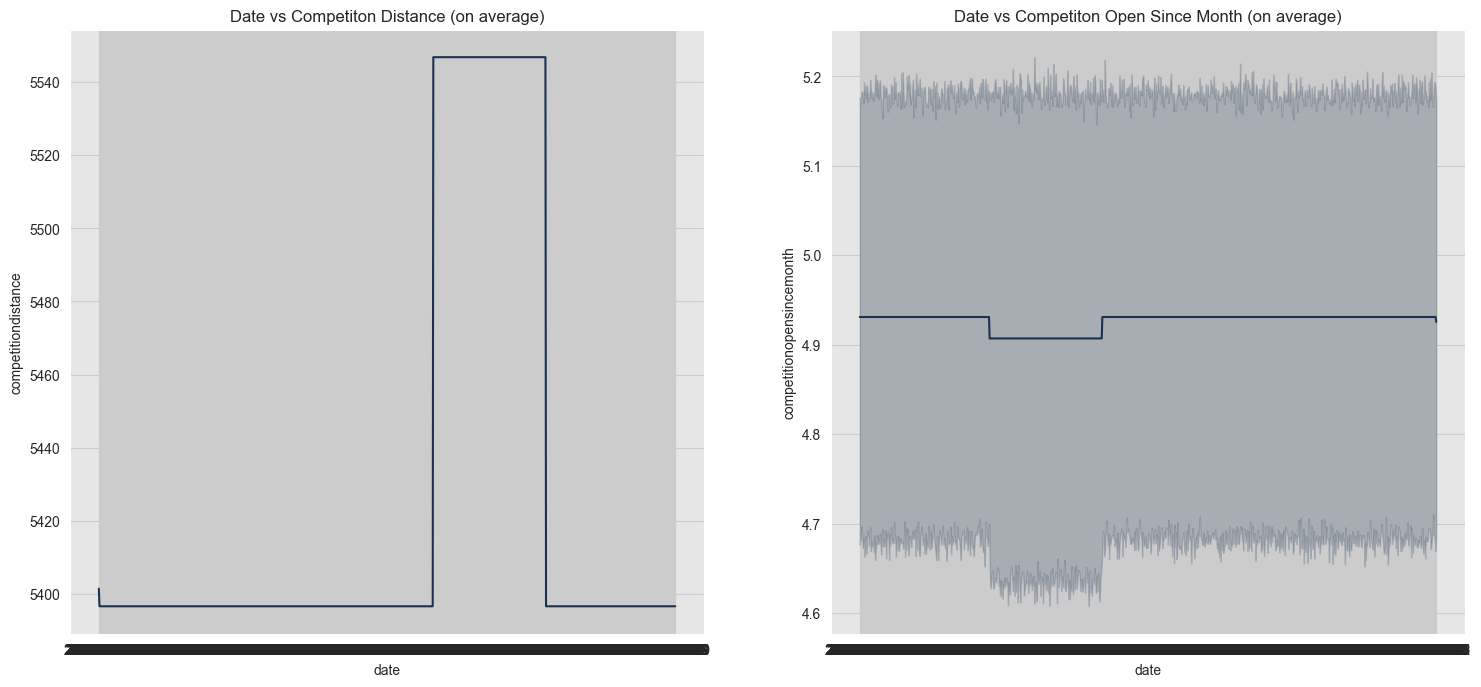

In [51]:
temp_df = df.copy()
temp_df.index = temp_df.date
temp_df = temp_df.groupby(temp_df.index).mean()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
sns.lineplot(x = "date", y = "competitiondistance" , data=temp_df, ax=axes[0])
sns.lineplot(x = "date", y = "competitionopensincemonth"  , data=df, ax=axes[1])

axes[0].set_title("Date vs Competiton Distance (on average)")
axes[1].set_title("Date vs Competiton Open Since Month (on average)")
plt.show()



In [52]:
df_store.describe().T

count         mean          std     min     25%  \
Store                      1115.0   558.000000   322.017080     1.0   279.5   
CompetitionDistance        1112.0  5404.901079  7663.174720    20.0   717.5   
CompetitionOpenSinceMonth   761.0     7.224704     3.212348     1.0     4.0   
CompetitionOpenSinceYear    761.0  2008.668857     6.195983  1900.0  2006.0   
Promo2                     1115.0     0.512108     0.500078     0.0     0.0   
Promo2SinceWeek             571.0    23.595447    14.141984     1.0    13.0   
Promo2SinceYear             571.0  2011.763573     1.674935  2009.0  2011.0   

                              50%     75%      max  
Store                       558.0   836.5   1115.0  
CompetitionDistance        2325.0  6882.5  75860.0  
CompetitionOpenSinceMonth     8.0    10.0     12.0  
CompetitionOpenSinceYear   2010.0  2013.0   2015.0  
Promo2                        1.0     1.0      1.0  
Promo2SinceWeek              22.0    37.0     50.0  
Promo2SinceYear            2012.0  2013.0   2015.0

<AxesSubplot:xlabel='Store', ylabel='CompetitionOpenSinceMonth'>

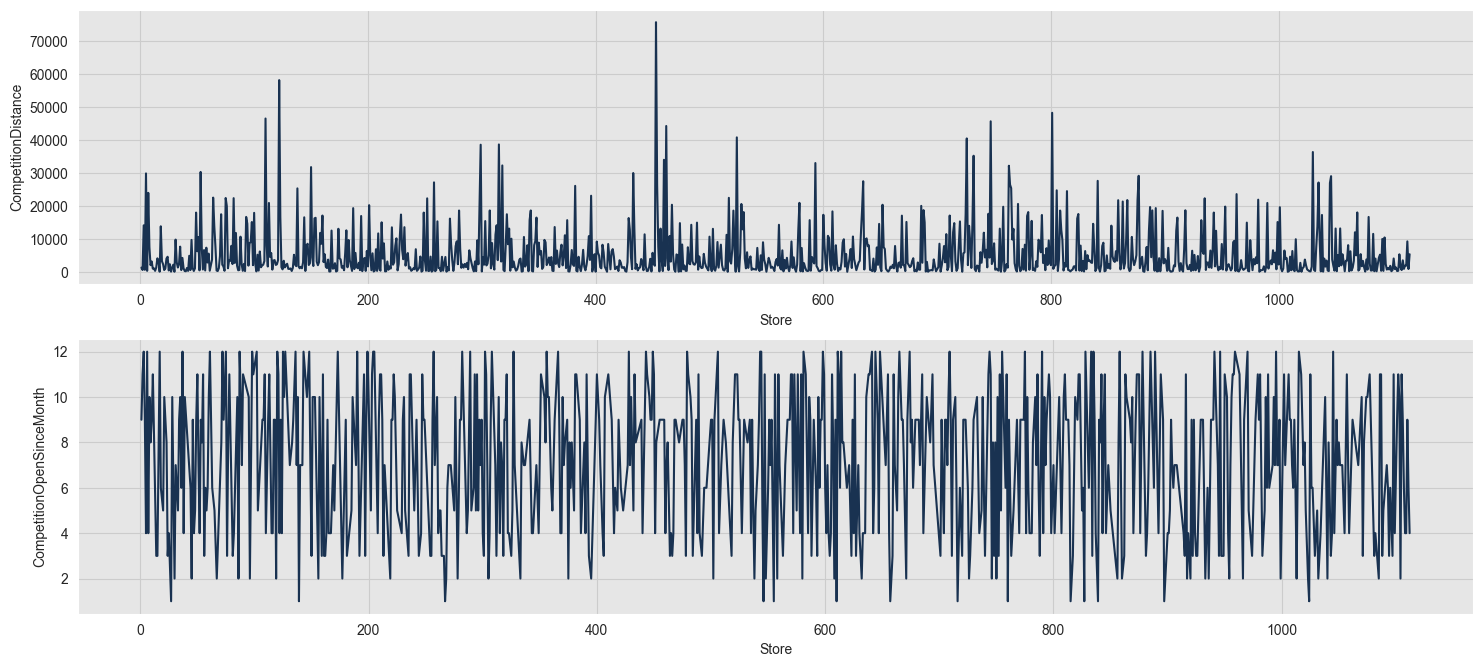

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
sns.lineplot(x = "Store", y = "CompetitionDistance" , data=df_store, ax=axes[0])
sns.lineplot(x = "Store", y = "CompetitionOpenSinceMonth"  , data=df_store, ax=axes[1])

<AxesSubplot:xlabel='CompetitionDistance', ylabel='Count'>

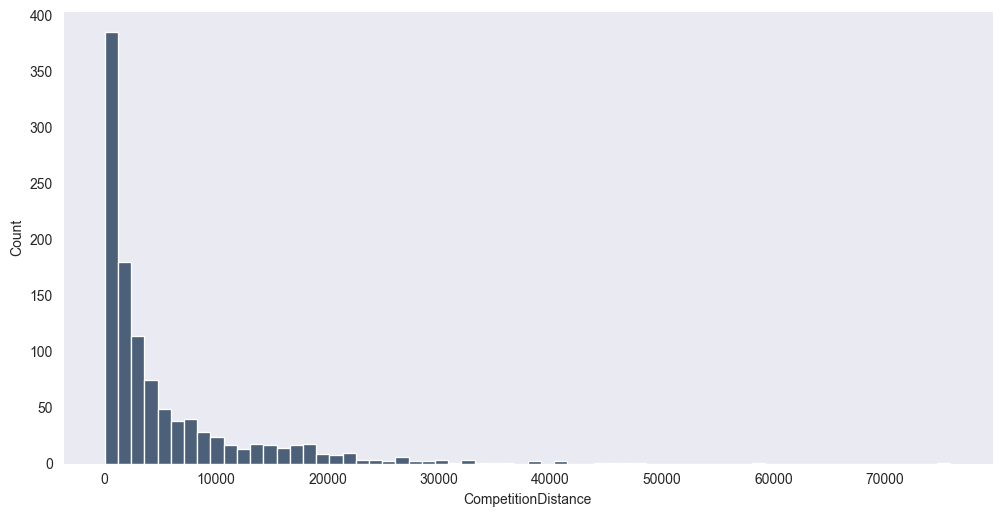

In [54]:
sns.set_style("dark")
sns.histplot(data=df_store, x="CompetitionDistance")


Text(0.5, 1.0, 'Number of Different Assortments per Store Type')

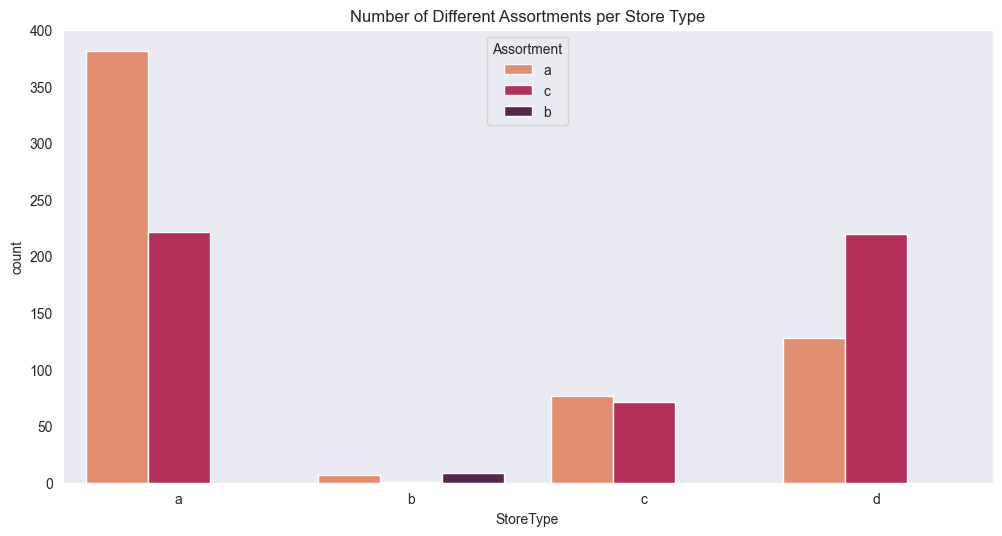

In [55]:
sns.countplot(x="StoreType",hue="Assortment",order=["a","b","c","d"], 
                                     data=df_store,palette="rocket_r").set_title("Number of Different Assortments per Store Type")

## Aggreded Plots

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x='timestamp', y='sales', data=df, ax=ax)
ax.set(title='Rossmanm - Sales (Hourly)', ylabel="€");

In [57]:
# Aggregate Sales by day
daily_data_df = df \
    .groupby([ "date",'year', 'month', 'day', 'dayofyear'], as_index=False)\
    .agg({'sales': np.mean}) \
    .set_index('date')

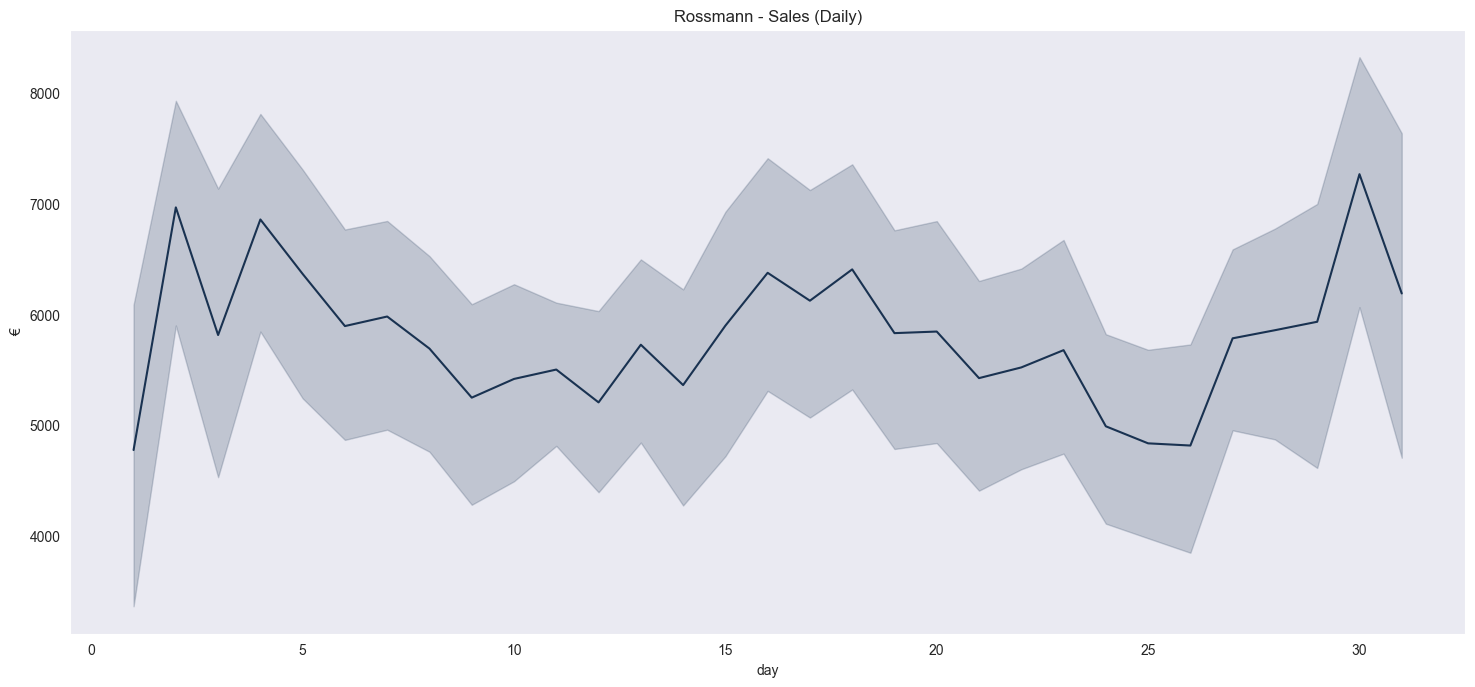

In [58]:
# Plot Sales on daily basis 
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x='day', y='sales', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Rossmann - Sales (Daily)', ylabel="€");

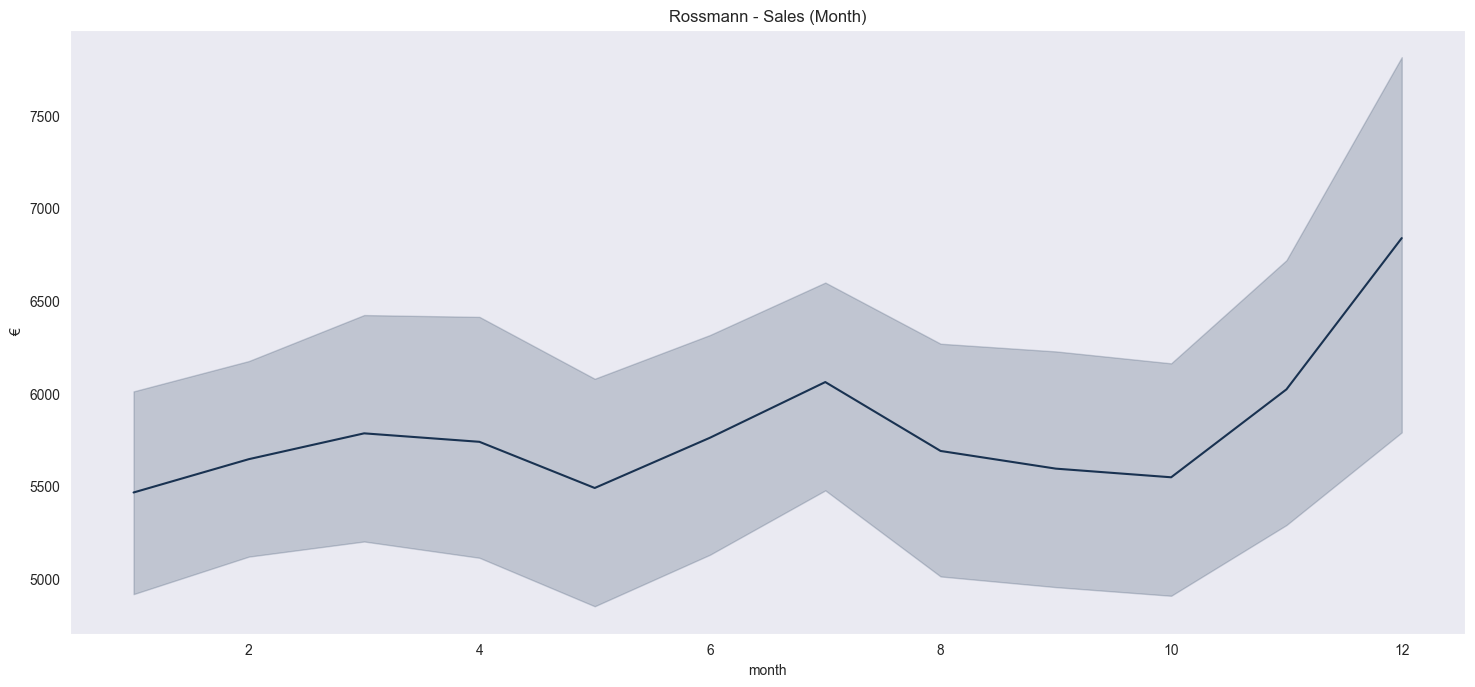

In [59]:
# Plot Sales on month basis 
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x='month', y='sales', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Rossmann - Sales (Month)', ylabel="€");

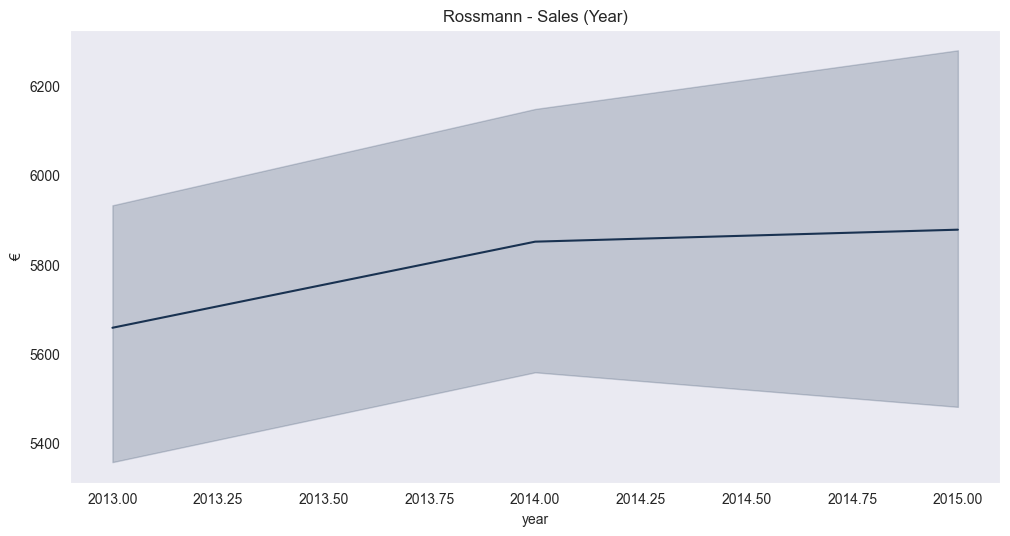

In [60]:
# Plot Sales on year basis 
fig, ax = plt.subplots()
sns.lineplot(x='year', y='sales', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Rossmann - Sales (Year)', ylabel="€");

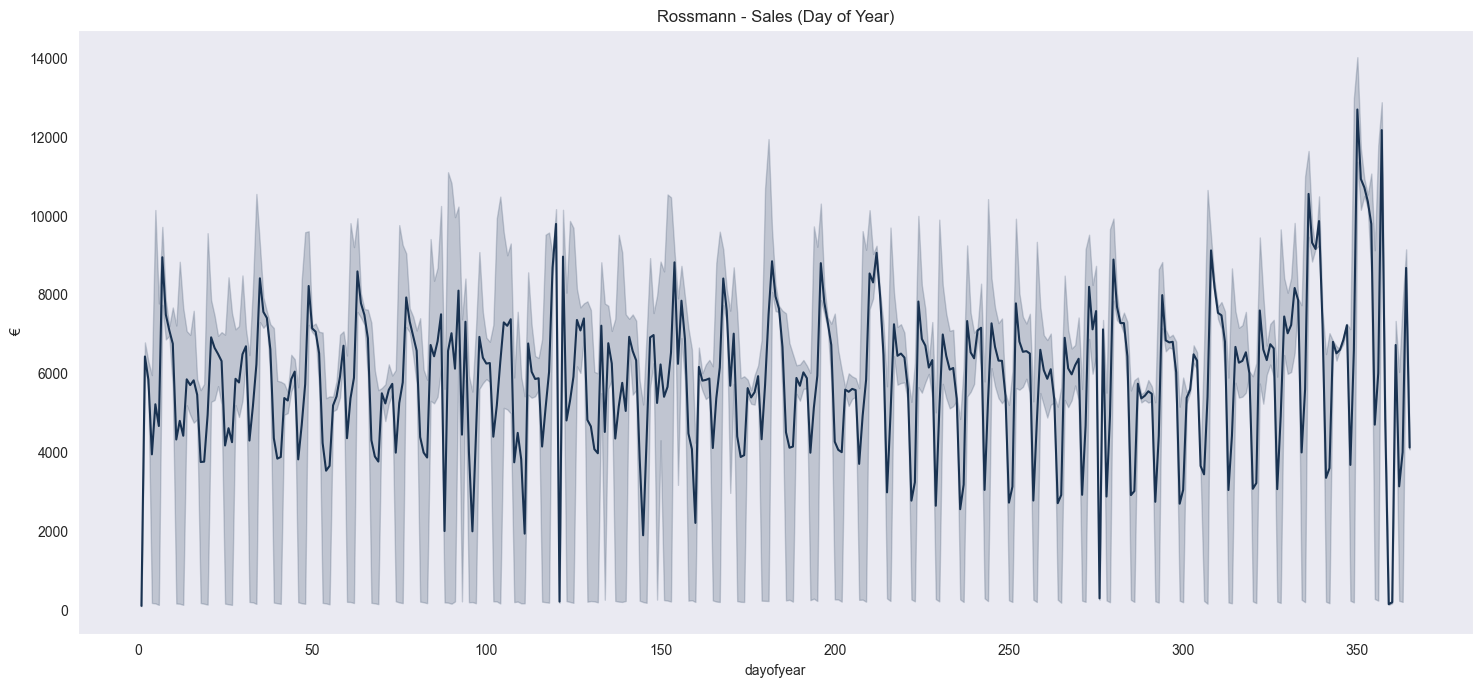

In [61]:
# Plot Sales on month basis 
fig, ax = plt.subplots(figsize=(18,8))
sns.lineplot(x='dayofyear', y='sales', data=daily_data_df.reset_index(), ax=ax)
ax.set(title='Rossmann - Sales (Day of Year)', ylabel="€");

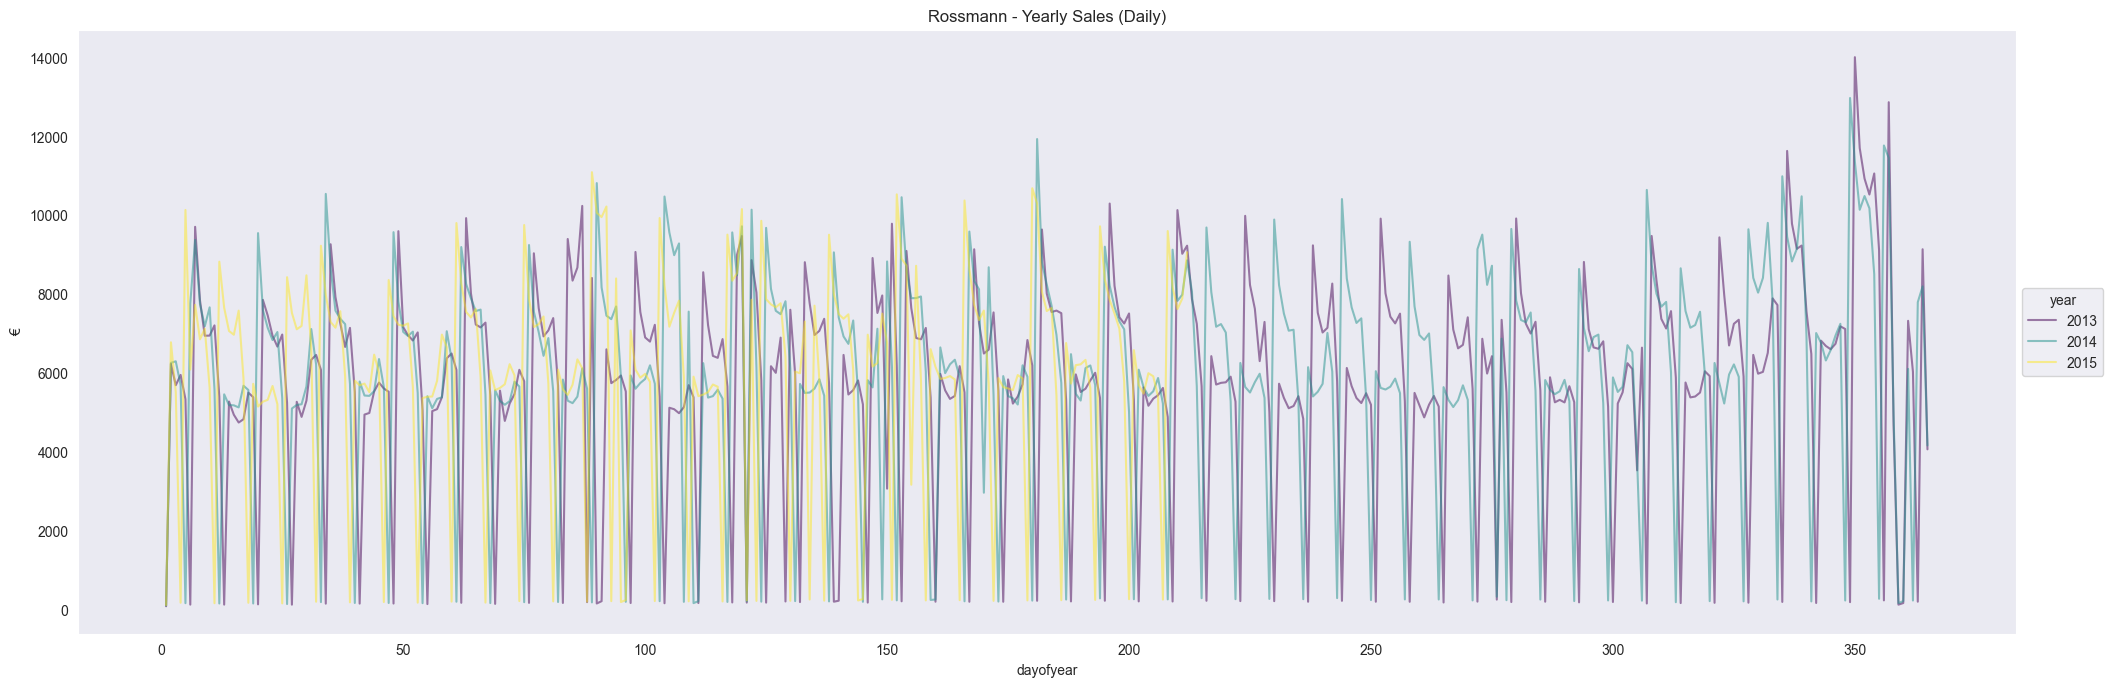

In [62]:
# Plot yearly seasonality
fig, ax = plt.subplots(figsize=(25,8)) 

pd.pivot_table(data=daily_data_df[['year', 'dayofyear', 'sales']], index='dayofyear', columns='year') \
    ['sales'] \
    .plot(cmap='viridis', alpha=0.5, ax=ax)

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Rossmann - Yearly Sales (Daily)', ylabel="€");

# Smoothing

Usuall the first question of data analysis is "Can we extract general, global pattern here?" In time series with cyclic seasonal variation, 
this means that we want to smooth out this seasonality and let the global trend manifest itself. Most classical, first go-to way for this 
smoothing is to use Moving Average.

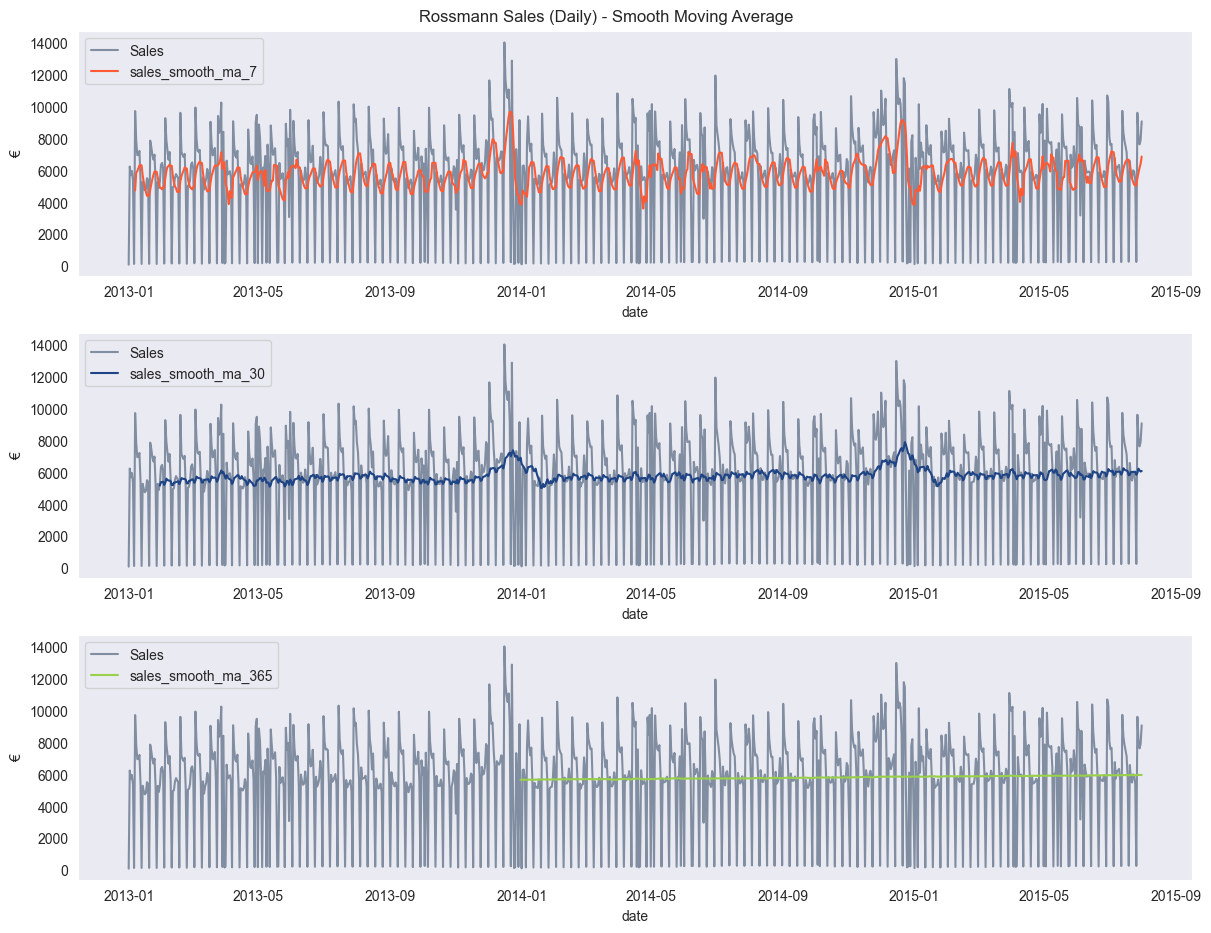

In [63]:
# Plot moving average of different length (week, month, year)
ma = [7, 30, 365]

smooth_daily_data_df = daily_data_df \
    .reset_index() \
    .assign(date = lambda x: x['date'].transform(pd.to_datetime))

# Smooth and plot
fig, ax = plt.subplots(3, 1, figsize=(12, 9), constrained_layout=True)

for i, m in enumerate(ma):

    smooth_daily_data_df[f'sales_smooth_ma_{m}'] = smooth_daily_data_df['sales'].rolling(window=m).mean()

    sns.lineplot(x='date', y='sales', label='Sales', data=smooth_daily_data_df, alpha=0.5, ax=ax[i])
    sns.lineplot(x='date', y=f'sales_smooth_ma_{m}', label=f'sales_smooth_ma_{m}', data=smooth_daily_data_df, color=sns_c[i + 1], ax=ax[i])
    ax[i].legend(loc='upper left')
    ax[i].set(title='', ylabel="€");

plt.suptitle('Rossmann Sales (Daily) - Smooth Moving Average', y=1.02);

Using the moving average of 365 units relfects the yearly structure of the data (lowest panel in the plot above).

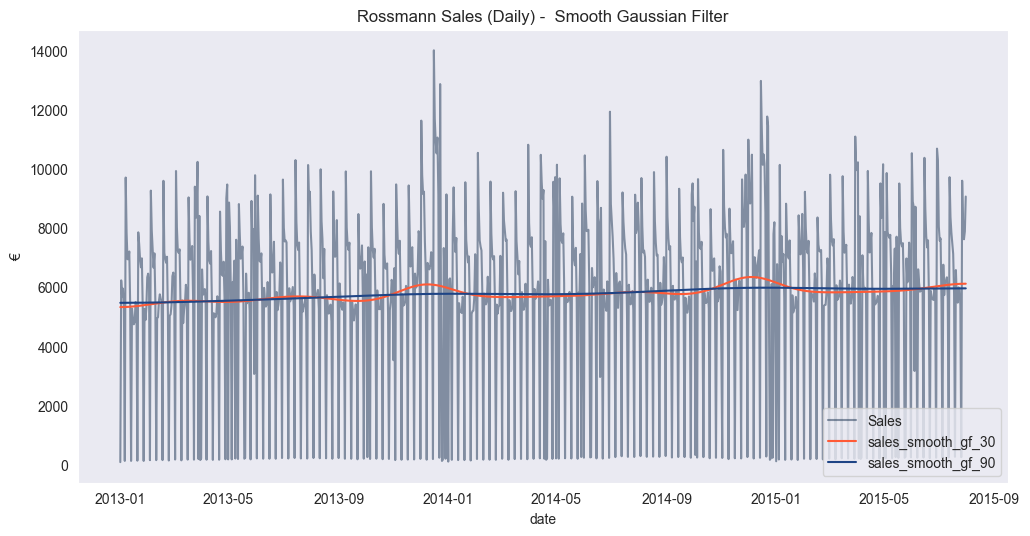

In [64]:
# Smooth data with gaussion filter
smooth_daily_data_df = smooth_daily_data_df \
    .assign(sales_smooth_gf_30 = lambda x: gaussian_filter(input=x['sales'], sigma=30)) \
    .assign(sales_smooth_gf_90 = lambda x: gaussian_filter(input=x['sales'], sigma=90))

# Plot data
fig, ax = plt.subplots()
sns.lineplot(x='date', y='sales', label='Sales', data=smooth_daily_data_df, alpha=0.5, ax=ax)
sns.lineplot(x='date', y='sales_smooth_gf_30', label='sales_smooth_gf_30', data=smooth_daily_data_df, color=sns_c[1], ax=ax)
sns.lineplot(x='date', y='sales_smooth_gf_90', label='sales_smooth_gf_90', data=smooth_daily_data_df, color=sns_c[2], ax=ax)
ax.legend(loc='lower right')
ax.set(title='Rossmann Sales (Daily) -  Smooth Gaussian Filter', ylabel="€");

Let us use this smoothing to plot again the seasonality yearly Sales:

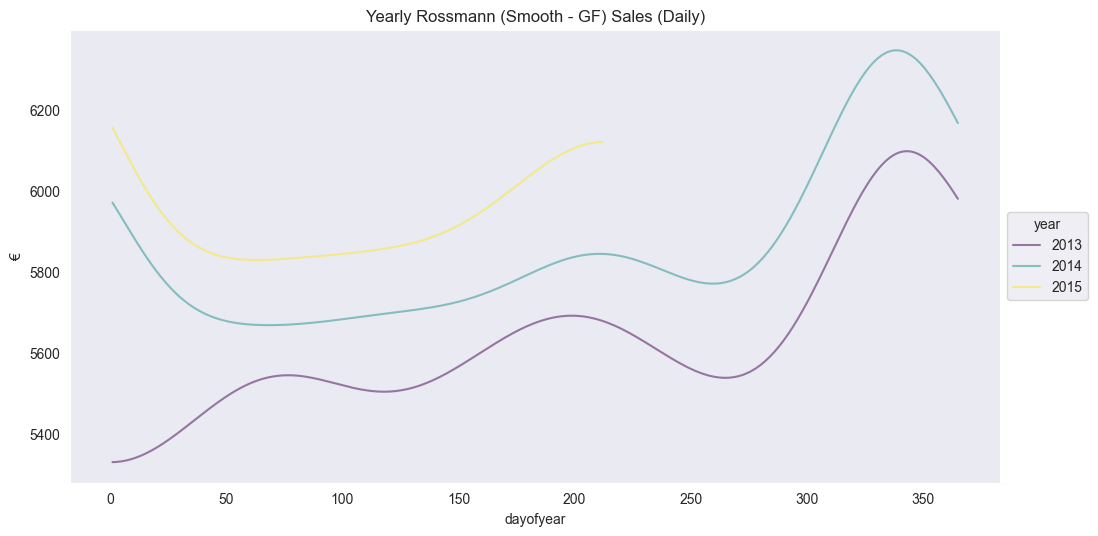

In [65]:
# Plot seasonal yearly temperature 
fig, ax = plt.subplots() 

pd.pivot_table(data=smooth_daily_data_df[['year', 'dayofyear', 'sales_smooth_gf_30']], index='dayofyear', columns='year') \
    ['sales_smooth_gf_30'] \
    .plot(cmap='viridis', alpha=0.5, ax=ax)

ax.legend(title='year', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Yearly Rossmann (Smooth - GF) Sales (Daily)', ylabel="€");

## Time Series Decomposition


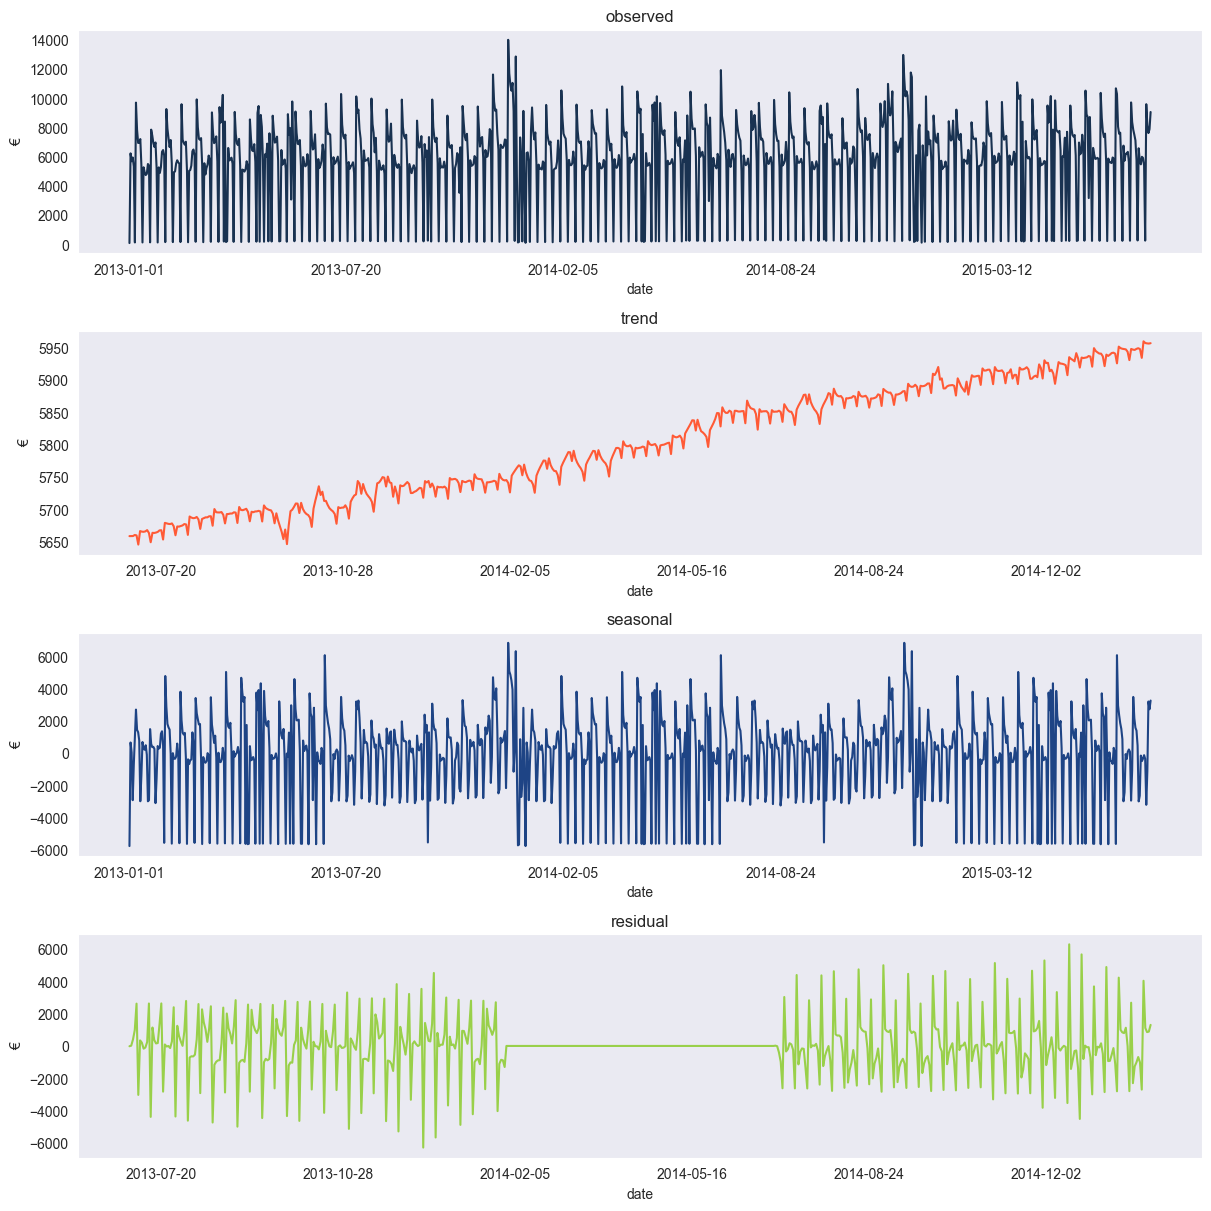

In [66]:
# We use the parameter `period` = 365 to extract the yearly seasonality. 
seas_decomp_yearly = seasonal_decompose(
    x=daily_data_df['sales'], 
    model='additive', 
    period=365
)

# Plot data
fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

seas_decomp_yearly.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel="€")
seas_decomp_yearly.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel="€")
seas_decomp_yearly.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel="€")
seas_decomp_yearly.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel="€");

We can now decompose the seasonal component from above. 

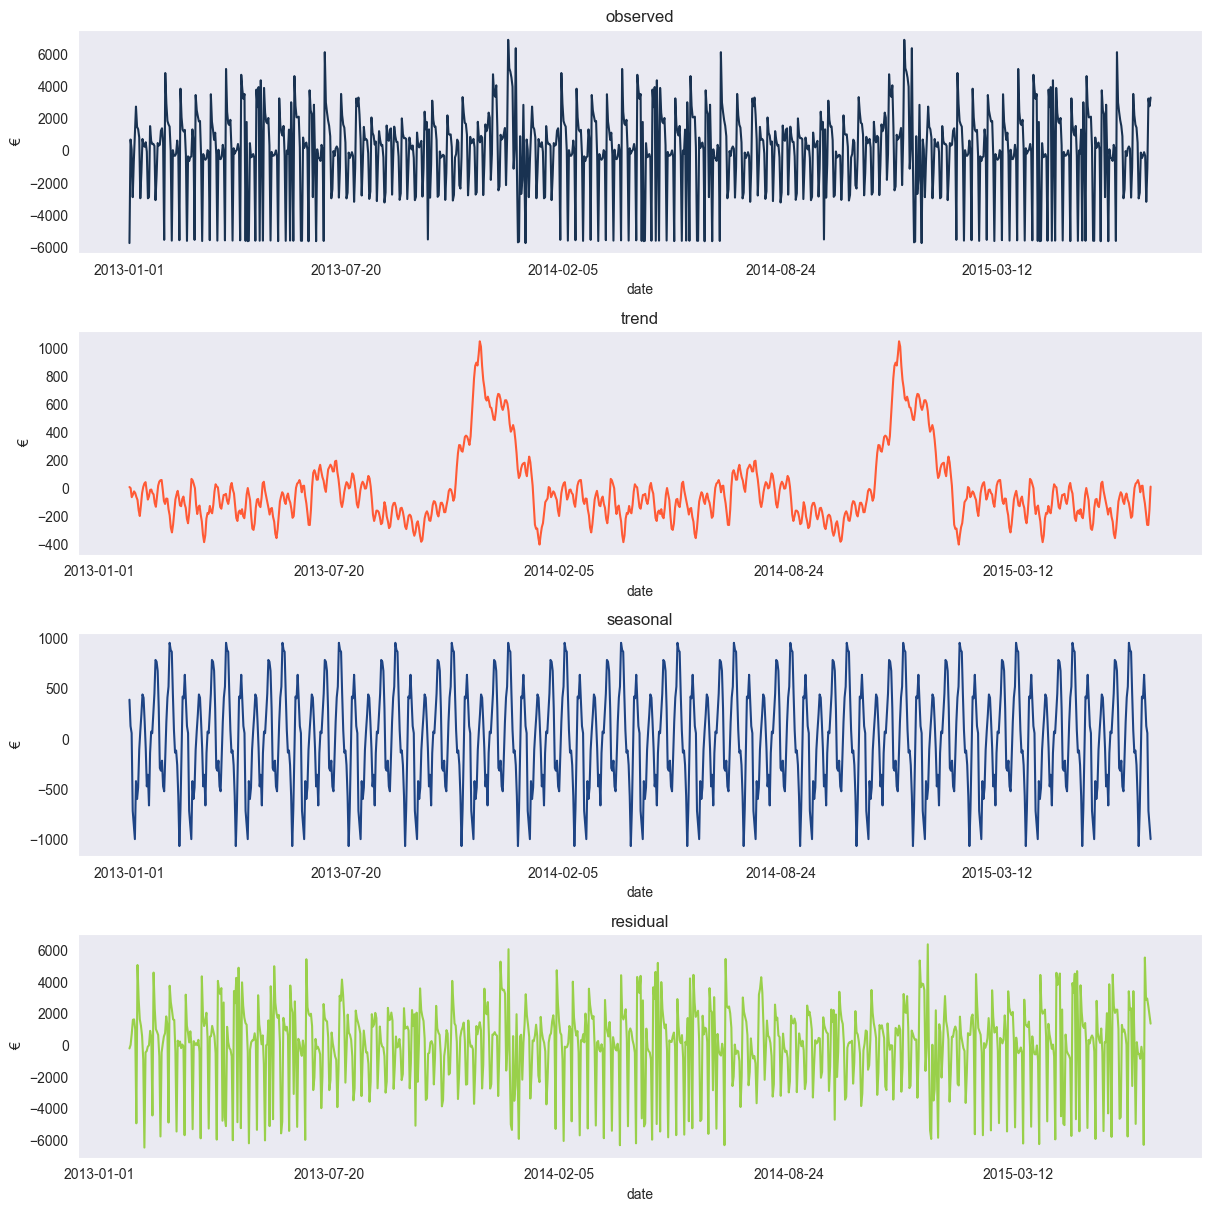

In [67]:
seas_decomp_monthly = seasonal_decompose(
    x=seas_decomp_yearly.seasonal, 
    model='additive', 
    period=52
)

# Plot data
fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

seas_decomp_monthly.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel="€")
seas_decomp_monthly.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel="€")
seas_decomp_monthly.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel="€")
seas_decomp_monthly.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel="€");


# ?????

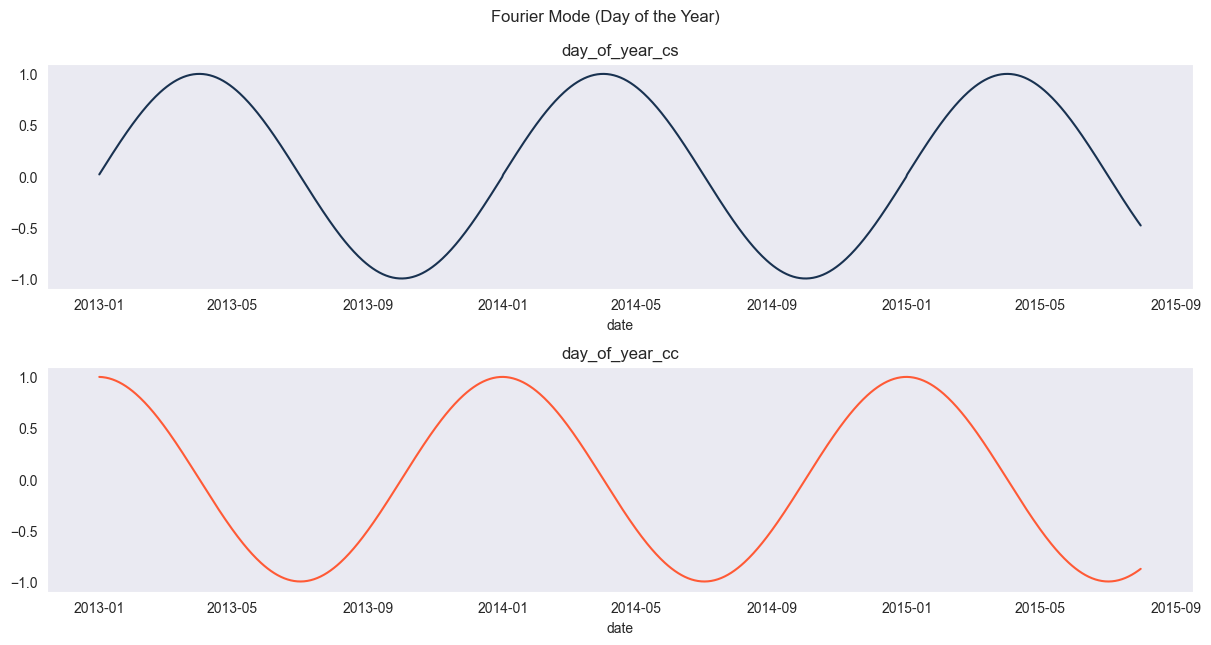

In [68]:
# Create linear trend and cyclical variables to model the day of the year. 
smooth_daily_data_df = smooth_daily_data_df.assign(
    index = lambda x: np.linspace(start=0, stop=x.shape[0]-1, num=x.shape[0]),
    day_of_year_cs = lambda x: np.sin(2*np.pi*x['dayofyear']/365.5),
    day_of_year_cc = lambda x: np.cos(2*np.pi*x['dayofyear']/365.5)
)

# Plot data
fig, ax = plt.subplots(2, 1, constrained_layout=True)
sns.lineplot(x='date', y='day_of_year_cs', data=smooth_daily_data_df, color=sns_c[0], ax=ax[0])
ax[0].set(title='day_of_year_cs', ylabel='')
sns.lineplot(x='date', y='day_of_year_cc', data=smooth_daily_data_df, color=sns_c[1], ax=ax[1])
ax[1].set(title='day_of_year_cc', ylabel='')
plt.suptitle('Fourier Mode (Day of the Year)', y=1.05);

Next, we use a linear model to fit each component:

In [69]:
# Define model
decomp_model = smf.ols(formula = 'sales ~ index + day_of_year_cs + day_of_year_cc', data=smooth_daily_data_df)

# Train model
decomp_red = decomp_model.fit()
print(decomp_red.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.365
Date:                Fri, 16 Jul 2021   Prob (F-statistic):              0.252
Time:                        13:43:57   Log-Likelihood:                -8840.4
No. Observations:                 942   AIC:                         1.769e+04
Df Residuals:                     938   BIC:                         1.771e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       5503.6398    189.532     29.

Finally, let us extract each component.

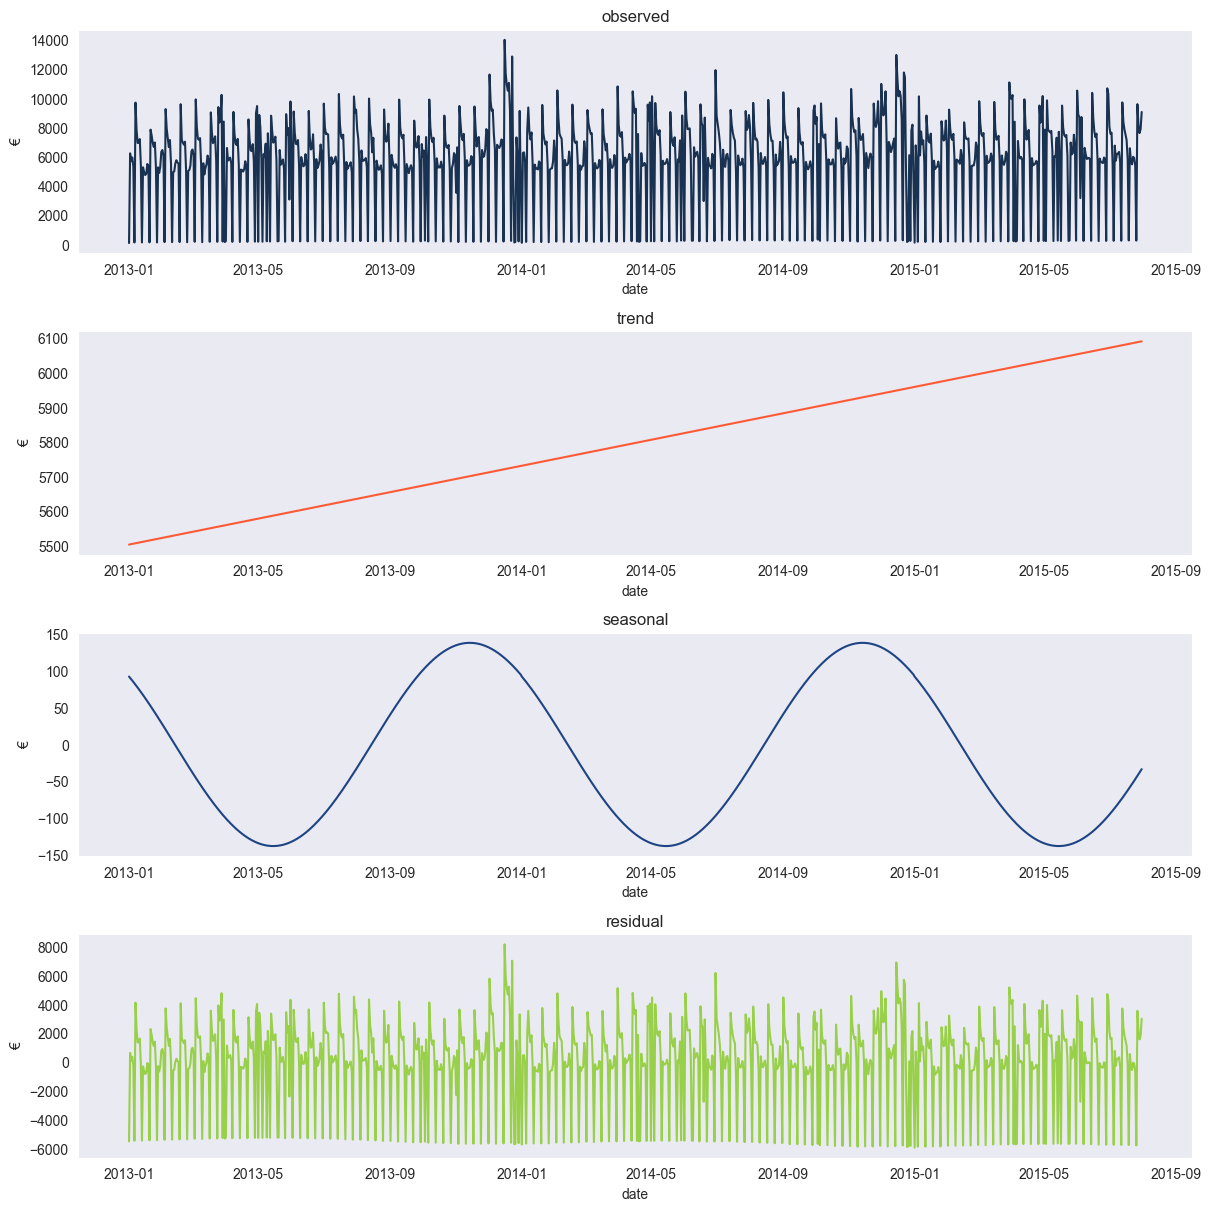

In [70]:
smooth_daily_data_df = smooth_daily_data_df.assign(
    decomp_trend = decomp_red.predict(smooth_daily_data_df.assign(day_of_year_cs = 0.0, day_of_year_cc = 0.0)),
    decomp_seas = decomp_red.predict(smooth_daily_data_df.assign(index = 0.0)) - decomp_red.params['Intercept'],
    decomp_error = lambda x: x['sales'] - x['decomp_trend'] - x['decomp_seas']
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)

sns.lineplot(x='date', y='sales', data=smooth_daily_data_df, color=sns_c[0], ax=ax[0])
ax[0].set(title='observed', ylabel="€")

sns.lineplot(x='date', y='decomp_trend', data=smooth_daily_data_df, color=sns_c[1], ax=ax[1])
ax[1].set(title='trend', ylabel="€")

sns.lineplot(x='date', y='decomp_seas', data=smooth_daily_data_df, color=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal', ylabel="€")

sns.lineplot(x='date', y='decomp_error', data=smooth_daily_data_df, color=sns_c[3], ax=ax[3])
ax[3].set(title='residual', ylabel="€");

#plt.savefig(f'../images/rossmann_daily_decomp_fourier.png', dpi=200, bbox_inches='tight');

## notebook 2

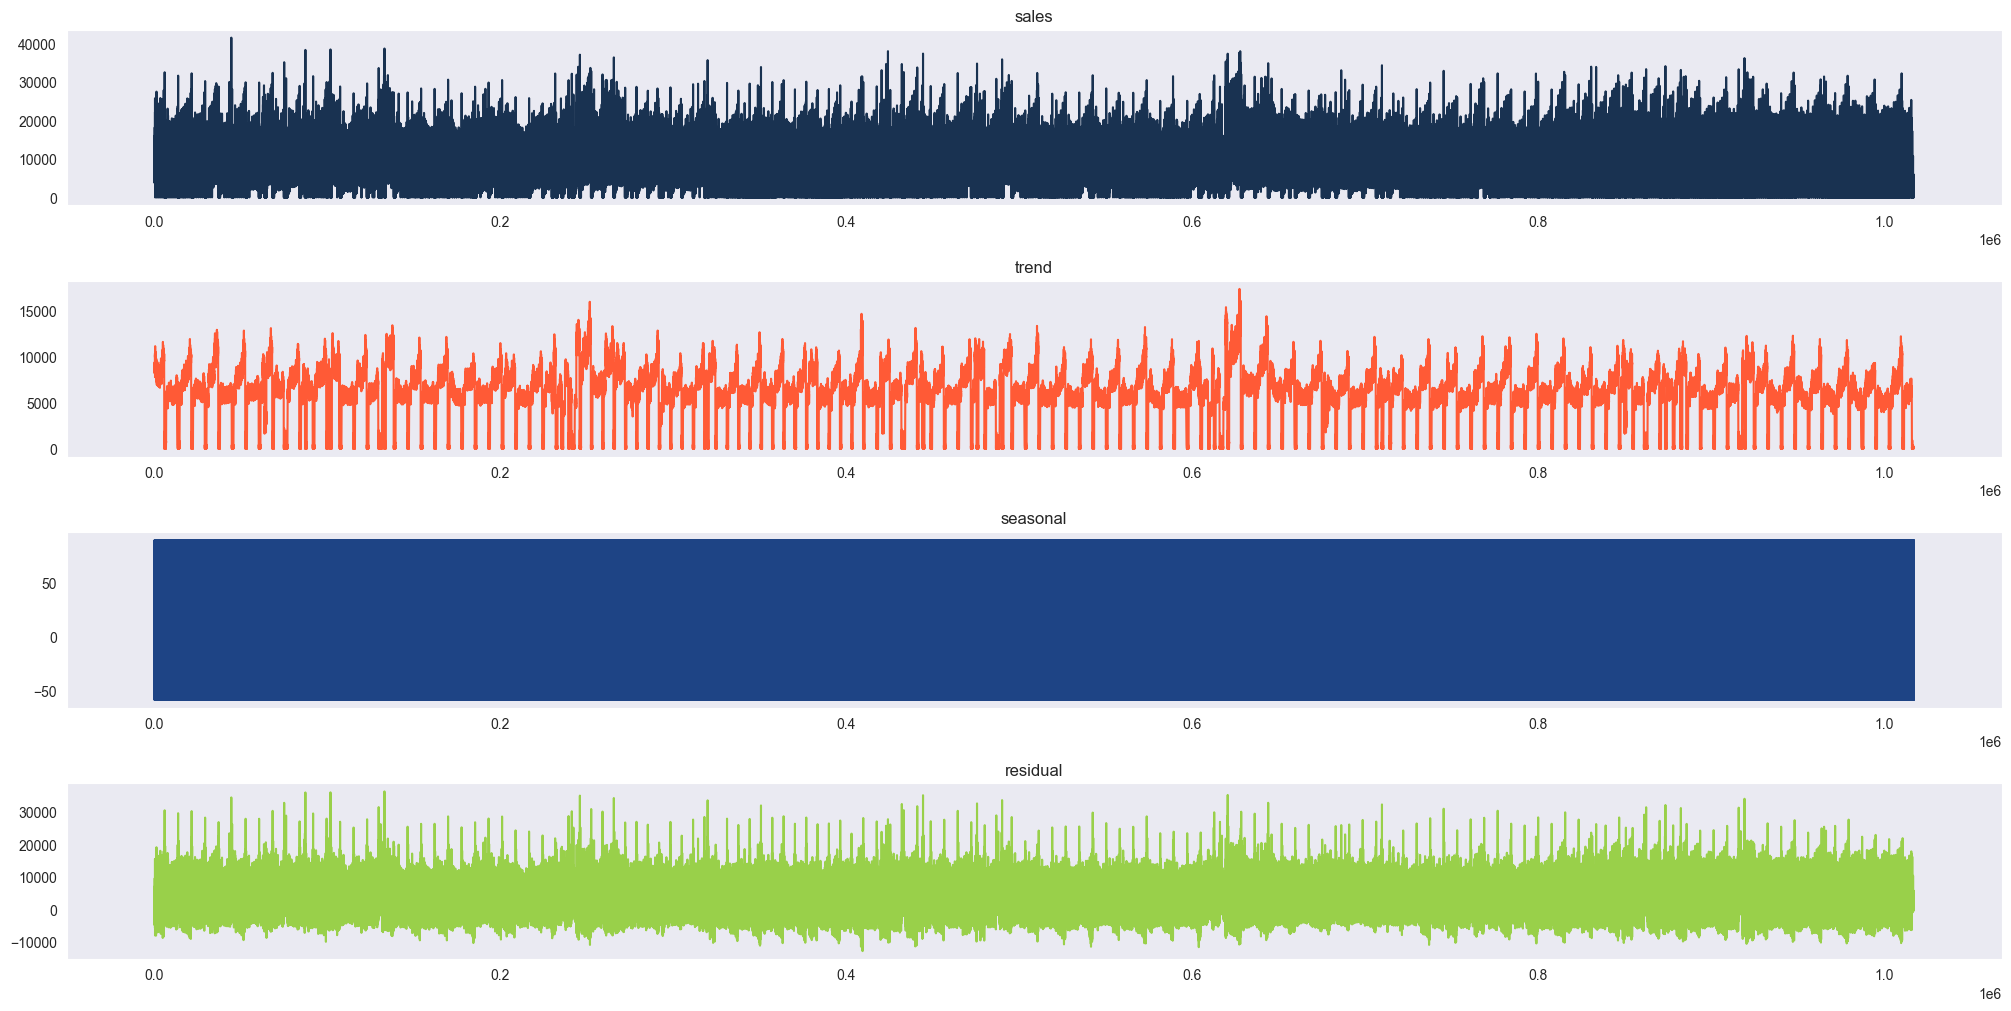

In [71]:
# Check decomposition of trend, seasonality and residue of original time series
decomposition = seasonal_decompose(x=df['sales'], 
                                   model='additive',
                                   period=30)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='sales')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

In [72]:
# Test for stationarity 

def stationarity_test(sales_st):
    
    # Calculate rolling mean and rolling standard deviation
    rolling_mean = sales_st.rolling(30).mean()
    rolling_std_dev = sales_st.rolling(30).std()
    
    # Plot the statistics
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='#FF5A36', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='#1E4485', label = 'Rolling Std Dev')
    plt.plot(sales_st, color='#99D04A',label='Original Time Series')
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # ADF test
    print("ADF Test:")
    adf_test = adfuller(sales_st,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('----'*10)
    
    # KPSS test
    print("KPSS Test:")
    kpss_test = kpss(sales_st, regression='c', nlags="legacy", store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('----'*10)
    
stationarity_test(df['sales'])

ADF Test:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x147217f70> (for post_execute):


KeyboardInterrupt: 

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 28 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   store                      1017209 non-null  int64         
 1   dayofweek                  1017209 non-null  int64         
 2   date                       1017209 non-null  object        
 3   sales                      1017209 non-null  int64         
 4   customers                  1017209 non-null  int64         
 5   open                       1017209 non-null  int64         
 6   promo                      1017209 non-null  int64         
 7   stateholiday               1017209 non-null  object        
 8   schoolholiday              1017209 non-null  int64         
 9   storetype                  1017209 non-null  object        
 10  assortment                 1017209 non-null  object        
 11  competitiondistance        1017209 no